#### Importing required libraries for the project

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import sklearn
import seaborn as sns
import requests, zipfile, io, os, sys, time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor as RFR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader
import pickle5 as pickle

##1. **Regression and out-of-distribution prediction**:



### a. Download the wine quality datasets from https://archive.ics.uci.edu/ml/datasets/Wine+Quality


In [ ]:
zip_url = "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
response = requests.get(zip_url)                            # get zip file
if response.status_code == 200:                             # if 200 OK message reply for the file download
    # Extract the zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        zip_file.extractall("extracted_files")
        print("Zip file extracted successfully")
else:
    print("Zip file download failed!! Abort procedures.")
    sys.exit()

extracted_files = os.listdir("extracted_files")          #listing downloaded and extracted files
print(extracted_files)
redWineDf = pd.read_csv("extracted_files/winequality-red.csv",sep=';') #read red wine data
whiteWineDf = pd.read_csv("extracted_files/winequality-white.csv",sep=';')  #read white wine data
redWineTargetDf = redWineDf['quality']  #create red wine target vector
redWineParamDf = redWineDf.drop('quality',axis=1) # create red wine training parameters
whiteWineTargetDf = whiteWineDf['quality'] #create white wine target vector
whiteWineParamDf = whiteWineDf.drop('quality',axis=1) #create white wine training parameters

Zip file extracted successfully
['winequality-red.csv', 'winequality-white.csv', 'winequality.names']


### b. Explore, visualize, and pre-process the data as appropriate. [1]

In [ ]:
#check the distribution of the values for all the columns in the red wine data set.
print(redWineParamDf.describe())
print(redWineDf.info())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [ ]:
redWineParamDf.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
# Checking for distinct values in the data corpus
for col in redWineParamDf.columns.values: # For each column
    list_vals = pd.unique(redWineParamDf[col])    # Create a list of unique values
    print(str(len(list_vals)) + ' \tunique values for '+col)
    if len(list_vals) < 10: # If the column has less than 10 unique values then print them
        list_str = ', '.join(map(str, list_vals))
        print('  These are: '+list_str)

96 	unique values for fixed acidity
143 	unique values for volatile acidity
80 	unique values for citric acid
91 	unique values for residual sugar
153 	unique values for chlorides
60 	unique values for free sulfur dioxide
144 	unique values for total sulfur dioxide
436 	unique values for density
89 	unique values for pH
96 	unique values for sulphates
65 	unique values for alcohol


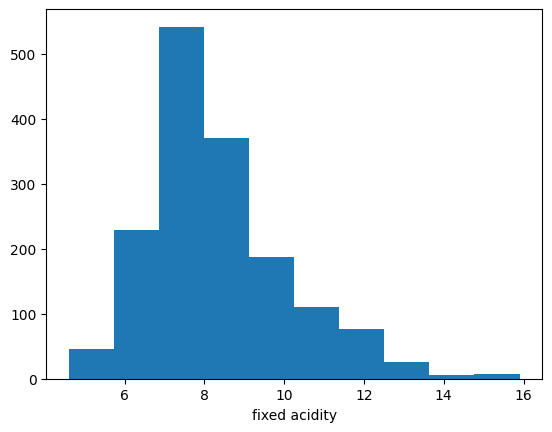

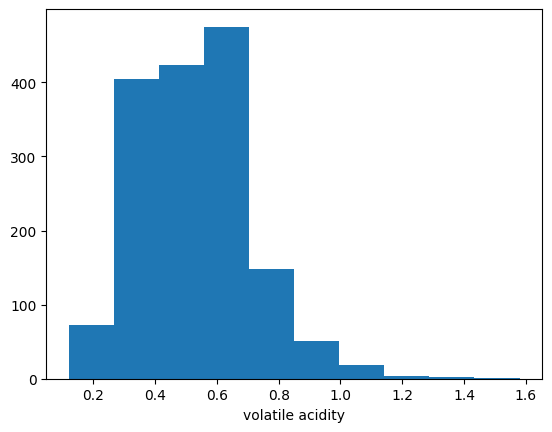

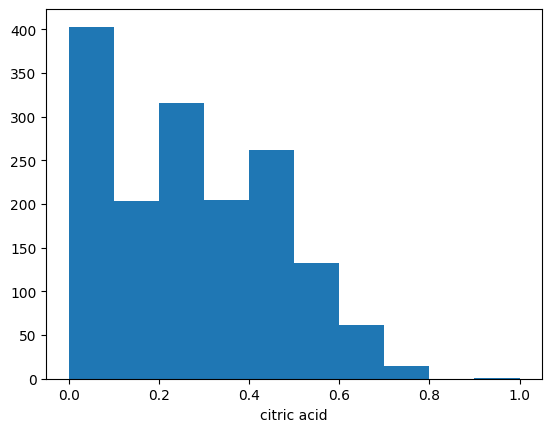

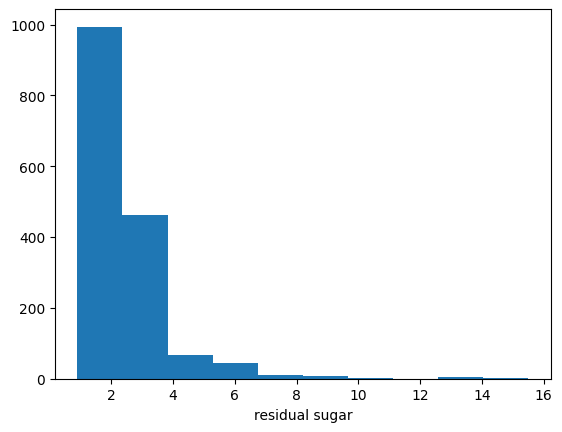

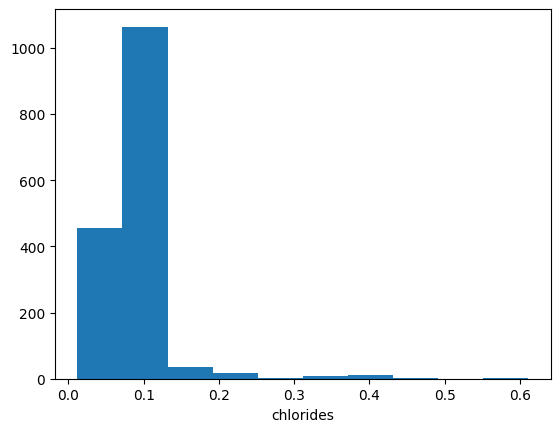

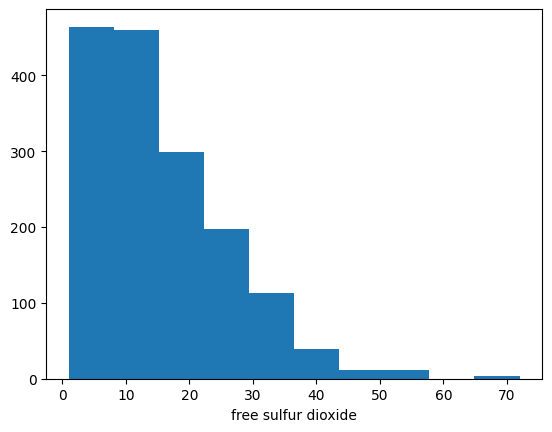

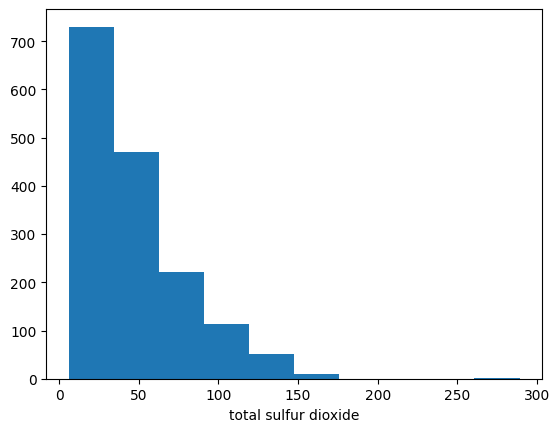

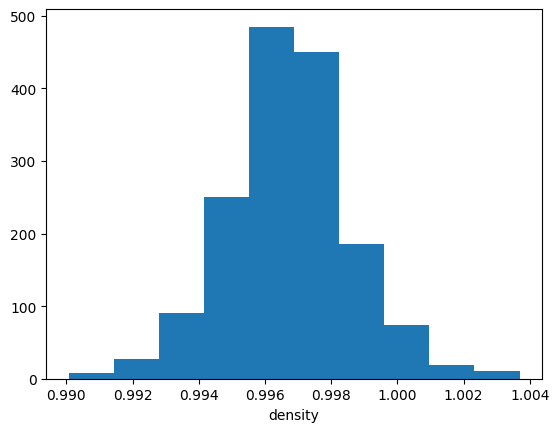

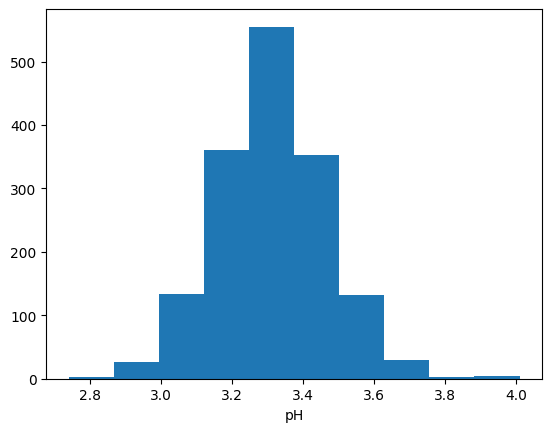

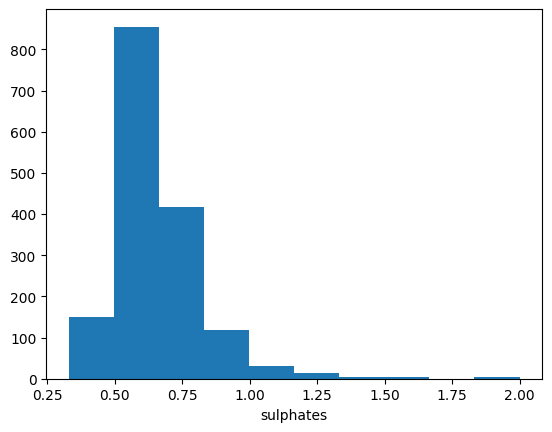

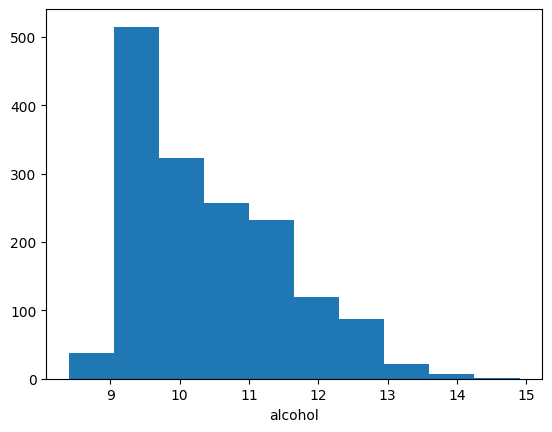

In [ ]:
#plotting histogram plots for the columns
for col in redWineParamDf.columns.values:
  if (redWineParamDf[col].dtypes == 'int64') | (redWineParamDf[col].dtypes == 'float64'):
    plt.hist(redWineParamDf[col],10 if len(pd.unique(redWineParamDf[col]))>20 else len(pd.unique(redWineParamDf[col])))
    plt.xlabel(col)
    plt.show()

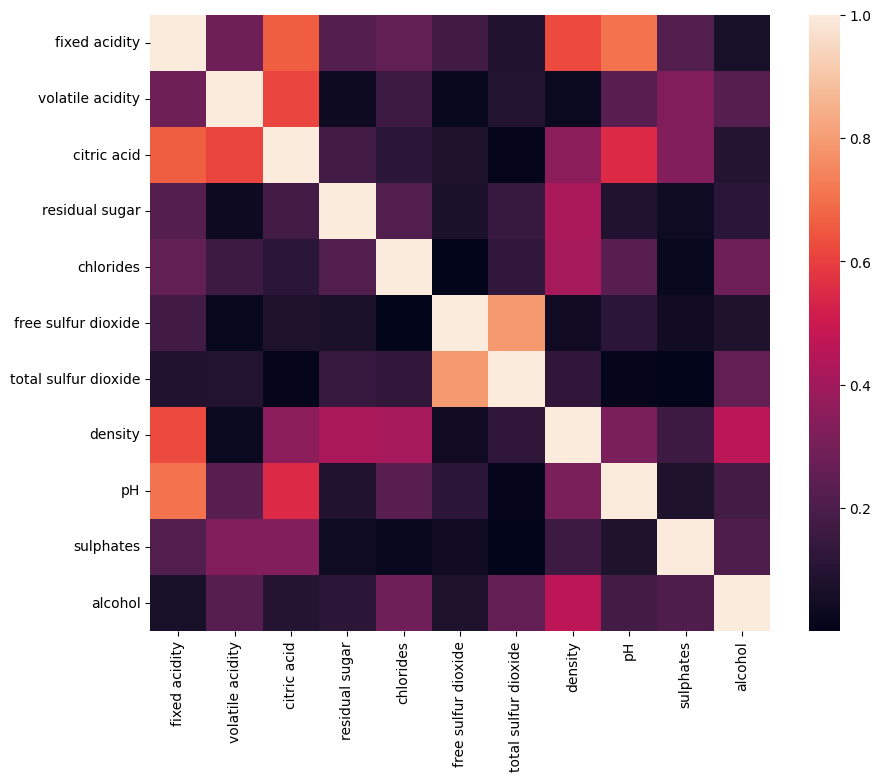

In [ ]:
#plotting the correlation between the different features available in the data set.
redCorrMatrix = redWineParamDf.corr(method='spearman') # Use spearman for non-linear
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(abs(redCorrMatrix), annot=False) # Show absolute value
plt.show()

In [ ]:
#preprocessing data by restricting it to 0 to 1 range via min max scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

#scale the data and store it into new data structures.
redWineNormParamDf = scaler.fit_transform(redWineParamDf)
with open('scalerRedWine.pkl', 'wb') as f:
    pickle.dump(scaler, f)

whiteWineNormParamDf = scaler.fit_transform(whiteWineParamDf)
with open('scalerWhiteWine.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
#check the distribution of the values for all the columns in the white wine data set.
print(whiteWineParamDf.describe())
print(whiteWineDf.info())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

In [ ]:
# Checking for distinct values in the data corpus
for col in whiteWineParamDf.columns.values: # For each column
    list_vals = pd.unique(whiteWineParamDf[col])    # Create a list of unique values
    print(str(len(list_vals)) + ' \tunique values for '+col)
    if len(list_vals) < 10: # If the column has less than 10 unique values then print them
        list_str = ', '.join(map(str, list_vals))
        print('  These are: '+list_str)

68 	unique values for fixed acidity
125 	unique values for volatile acidity
87 	unique values for citric acid
310 	unique values for residual sugar
160 	unique values for chlorides
132 	unique values for free sulfur dioxide
251 	unique values for total sulfur dioxide
890 	unique values for density
103 	unique values for pH
79 	unique values for sulphates
103 	unique values for alcohol


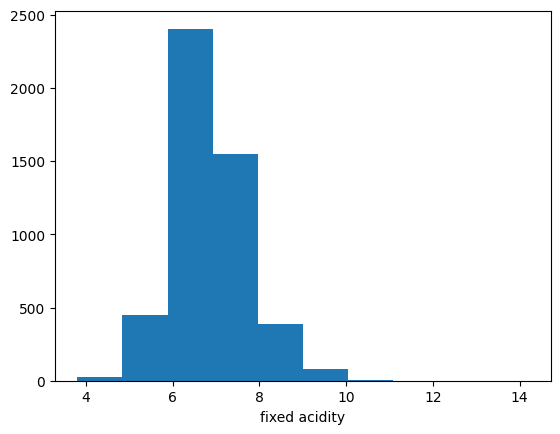

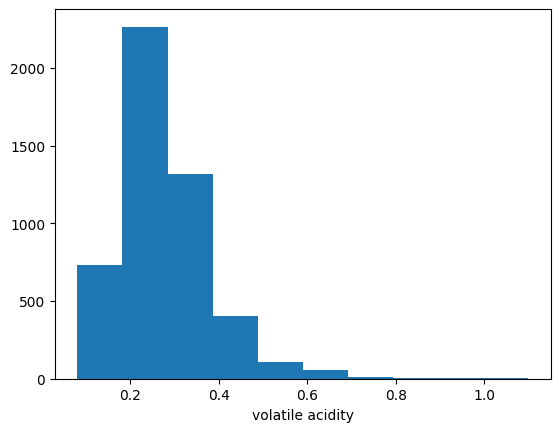

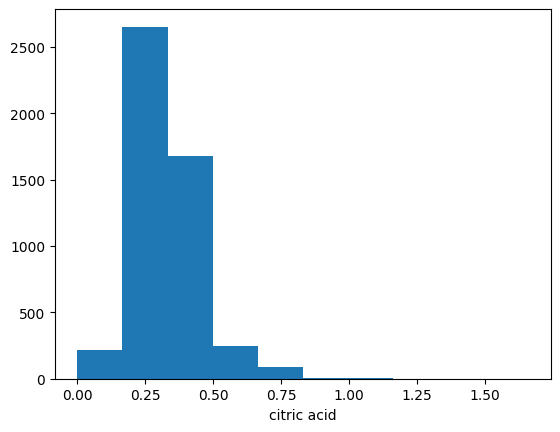

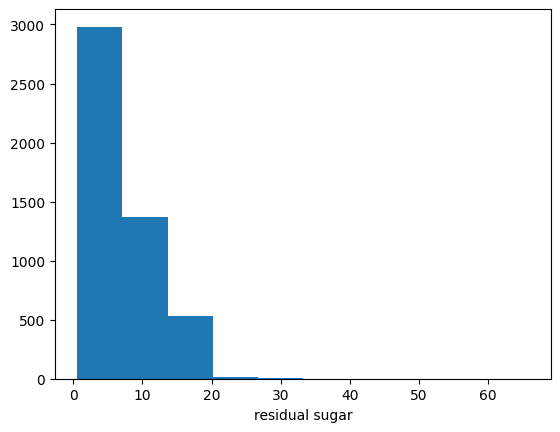

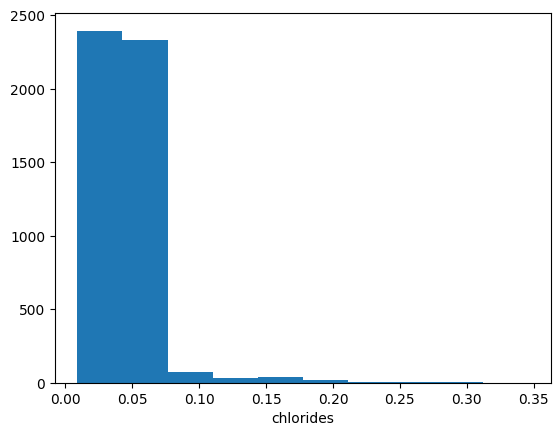

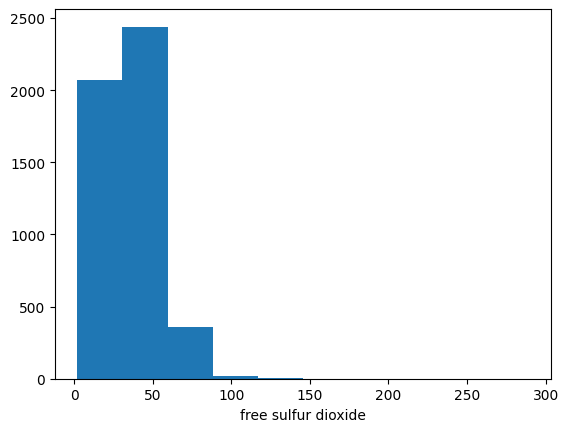

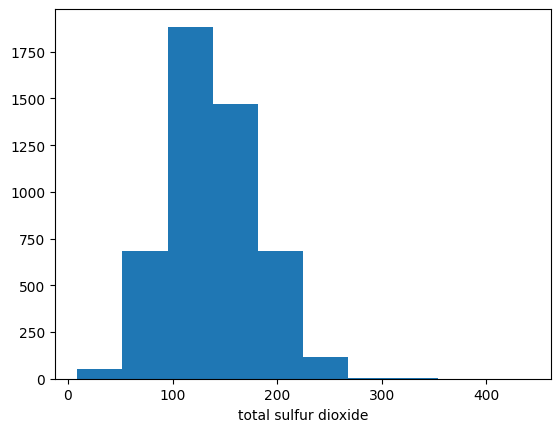

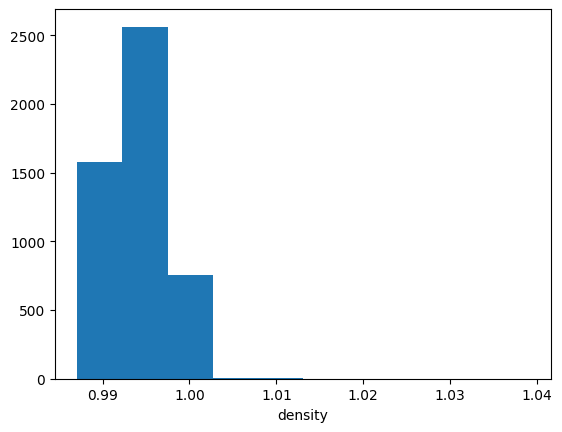

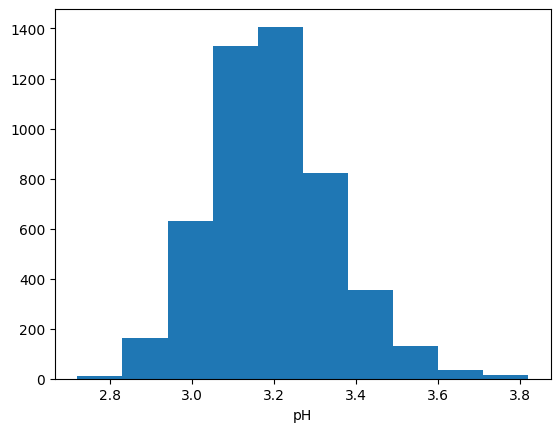

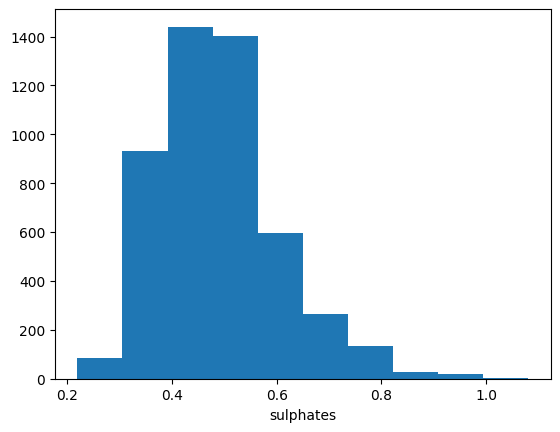

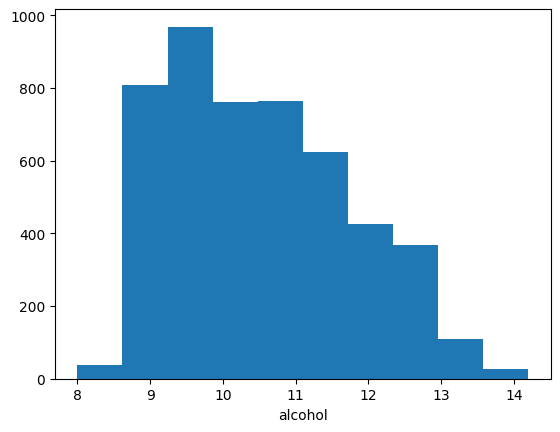

In [ ]:
#plotting histogram plots for the columns
for col in whiteWineParamDf.columns.values:
  if (whiteWineParamDf[col].dtypes == 'int64') | (whiteWineParamDf[col].dtypes == 'float64'):
    plt.hist(whiteWineParamDf[col],10 if len(pd.unique(whiteWineParamDf[col]))>20 else len(pd.unique(whiteWineParamDf[col])))
    plt.xlabel(col)
    plt.show()

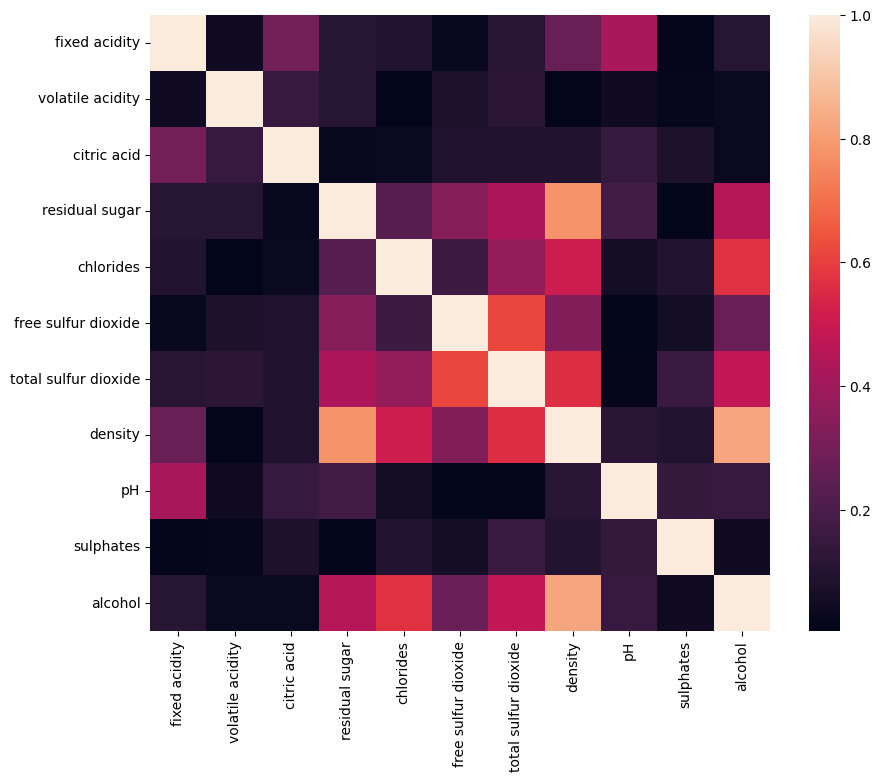

In [ ]:
#plotting the correlation matrix using the spearman kernel and plotting a heatmap to understand the corrrelation for white wine data
whiteCorrMatrix = whiteWineParamDf.corr(method='spearman') # Use spearman for non-linear
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(abs(whiteCorrMatrix), annot=False) # Show absolute value
plt.show()

Here the correlation heat map shows that none of the parameeters have correlation more than 0.9. Hence we shall take all of the features for initial training.

### c. Train, validate varying at least one hyperparameter, and test at least two types of models: [2]

    i. Random forest

    ii. Support vector regression with RBF kernel

    iii. Neural network with single hidden layer (output layer should have linear activation)


In [ ]:
#hyper parameter initialization and tuning
num_trees_range = [100, 200, 500, 1000, 2000]
test_size_split = [0.1, 0.15, 0.2]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(redWineNormParamDf, redWineTargetDf, test_size=0.2, random_state=42)

#### **i**. Random Forest Regressor training

In [ ]:
best_metric = [0,0,1000]    # storing the best metric in regard the nrmse from validation data

for test_split in test_size_split:
    #splitting into train and validate data sets from the training
    X_train_rfr_split, X_validate, y_train_rfr_split, y_validate = train_test_split(X_train, y_train, test_size=test_split, random_state=42)

    for num_trees in num_trees_range:
        # Initialize the Random Forest classifier
        random_forest = RFR(n_estimators=num_trees, criterion="squared_error", random_state=42)

        # Train the model
        random_forest.fit(X_train_rfr_split, y_train_rfr_split)

        # Make predictions
        predictions = random_forest.predict(X_validate)

        # Evaluate the Normalised Root mean square Error in predictions for the validation data
        rmse_RFR = np.sqrt(mean_squared_error(y_validate, predictions))
        nrmse_RFR = rmse_RFR / (np.max(y_validate)-np.min(y_validate))
        if (best_metric[2] > nrmse_RFR) :
            best_metric[2] = nrmse_RFR
            best_metric[1] = num_trees
            best_metric[0] = test_split
        else:
            break
print(f"Best Results in training for test_split : {best_metric[0]} number of trees : {best_metric[1]} NRMSE = {best_metric[2]}")

#now re-training the model based on best parameters achieved in training phase for results
random_forest = RFR(n_estimators=int(best_metric[1]), criterion="squared_error", random_state=42)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
rmse_RFR = np.sqrt(mean_squared_error(y_test, predictions))
nrmse_RFR = rmse_RFR / (np.max(y_test)-np.min(y_test))
print(f"Model NRMSE for Random Forest is {nrmse_RFR}")
print(f"R-squared score of the Random Forest regressor is {r2_score(y_test, np.round(predictions))}")

Best Results in training for test_split : 0.1 number of trees : 200 NRMSE = 0.13710156227740897
Model NRMSE for Random Forest is 0.11068248506425937
R-squared score of the Random Forest regressor is 0.38313483465084663


In [ ]:
with open('RFR_redWinePredictor.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

#### **ii**. SVM with Radial Basis Function kernel

In [ ]:
# hyper parameters for RBF kernel SVM regressor
gaMMa_range = np.logspace(-9, 3, 13)
C_range = np.logspace(-2, 10, 13)

In [ ]:
best_metric_SVR = [0.0,0.0,1000.0]

for C_value in C_range:
    for gaMMa in gaMMa_range:
        #splitting into train and validate data sets from the training
        X_train_svr_split, X_validate, y_train_svr_split, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        #Initialize the SVM with RBF kernel for regression
        svm_regressor = SVR(kernel='rbf',gamma=gaMMa,C=C_value)

        # Train the model
        svm_regressor.fit(X_train_svr_split, y_train_svr_split)

        # Make predictions
        predictions = svm_regressor.predict(X_validate)

        # Evaluate the model
        rmse_SVR = np.sqrt(mean_squared_error(y_validate, predictions))
        nrmse_SVR = rmse_SVR/ (np.max(y_validate)-np.min(y_validate))
        if (best_metric_SVR[2] > nrmse_SVR) :
            best_metric_SVR[2] = nrmse_SVR
            best_metric_SVR[1] = C_value
            best_metric_SVR[0] = gaMMa
        else:
            break

# retraining the model using the best metric parameters
svm_regressor = SVR(kernel='rbf',gamma=best_metric_SVR[0], C=best_metric_SVR[1])
svm_regressor.fit(X_train, y_train)
predictions = svm_regressor.predict(X_test)
rmse_SVR = np.sqrt(mean_squared_error(y_test, predictions))
nrmse_SVR = rmse_SVR/ (np.max(y_test)-np.min(y_test))
print(f"Best Results in training for gamma : {best_metric_SVR[0]} C value : {best_metric_SVR[1]} NRMSE = {best_metric_SVR[2]}")
print("\n\nNormalised Root Mean Squared Error SVR with RBF kernel :", nrmse_SVR)
print(f"R-squared score of the SVM regressor is {r2_score(y_test, np.round(predictions))}")

Best Results in training for gamma : 1.0 C value : 0.01 NRMSE = 0.16946713367272206


Normalised Root Mean Squared Error SVR with RBF kernel : 0.13843204338339374
R-squared score of the SVM regressor is 0.19664071489412582


#### **iii**. Neural Network training

In [ ]:
epoch_range = [50, 100, 200, 500]
loss_types = ['mean_squared_error']
optimiser_types = ['adam','sgd','adagrad','adadelta']
validation_splits = [0.1, 0.15, 0.2]

In [ ]:
best_metric_NN = ['','',0,0,1000]       # of the form [loss_type, optimiser_type, validation_split, no_of_epochs, nrmse]

for loss_type in loss_types:
    for optimiser_type in optimiser_types:
        for validation in validation_splits :
            for epoch in epoch_range:
                #splitting into test and validation data
                X_train_nn_split, X_validate, y_train_nn_split, y_validate = train_test_split(X_train, y_train, test_size=validation, random_state=42)

                # Build the neural network model
                model = Sequential([
                    Dense(32, activation='relu', input_shape=(X_train_nn_split.shape[1],)),  # Single hidden layer with 64 neurons
                    Dense(1, activation='linear')  # Output layer with linear activation
                ])

                # Compile the model
                model.compile(optimizer=optimiser_type, loss=loss_type)


                # Train the model
                history = model.fit(X_train_nn_split, y_train_nn_split, epochs=epoch, batch_size=32, validation_split=0.1, verbose=0)

                # Evaluate the model on the testing set
                y_pred = model.predict(X_validate)
                rmse_ANN = np.sqrt(mean_squared_error(y_validate, y_pred))
                nrmse_ANN = rmse_ANN/ (np.max(y_validate)-np.min(y_validate))
                if (best_metric_NN[4] > nrmse_SVR) :
                    best_metric_NN[4] = nrmse_SVR
                    best_metric_NN[3] = epoch
                    best_metric_NN[2] = validation
                    best_metric_NN[1] = optimiser_type
                    best_metric_NN[0] = loss_type
                else:
                    break


# re-training the NN model with optimised parameters
NN_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Single hidden layer with 64 neurons
    Dense(1, activation='linear')  # Output layer with linear activation
])

# Compile the model
NN_model.compile(optimizer=best_metric_NN[1], loss=best_metric_NN[0])

# Train the model
history = NN_model.fit(X_train, y_train, epochs=best_metric_NN[3], batch_size=32, validation_split=0.1)

# Evaluate the model on the testing set
y_pred = NN_model.predict(X_test)
rmse_ANN = np.sqrt(mean_squared_error(y_test, y_pred))
nrmse_ANN = rmse_ANN/ (np.max(y_test)-np.min(y_test))
print(f"Best Results in training for test_split : {best_metric_NN[2]} for loss type: {best_metric_NN[0]} NRMSE = {best_metric_NN[4]} in {best_metric_NN[3]} epochs for {best_metric_NN[1]} optimiser")
print("Normalised Root Mean Squared Error:", nrmse_ANN)
print(f"R-squared score of the NN based regressor is {r2_score(y_test, np.round(y_pred))}")

8/8 [==============================] - 0s 2ms/step
Epoch 1/50
36/36 [==============================] - 1s 6ms/step - loss: 31.7007 - val_loss: 28.1249
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 24.9447 - val_loss: 21.1024
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 17.8212 - val_loss: 13.9124
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 11.0500 - val_loss: 7.8146
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 5.8416 - val_loss: 3.6694
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 2.7314 - val_loss: 1.6236
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 1.3819 - val_loss: 0.9216
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.9854 - val_loss: 0.7939
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.9236 - val_loss: 0.7796
Epoch 10/50
36/36 [==============================] - 0s 3ms/

### d. Search the net about how to determine the importance of each variable, and find the importance in the final models tried. Comment on whether the same variables are important for different models. [1]

Feature 	 feature
 rank
  1 	 alcohol (0.272652)
  2 	 sulphates (0.151100)
  3 	 volatile acidity (0.108390)
  4 	 total sulfur dioxide (0.077636)
  5 	 chlorides (0.070043)
  6 	 pH (0.061484)
  7 	 residual sugar (0.058068)
  8 	 density (0.052488)
  9 	 fixed acidity (0.052336)
  10 	 citric acid (0.048978)
  11 	 free sulfur dioxide (0.046824)


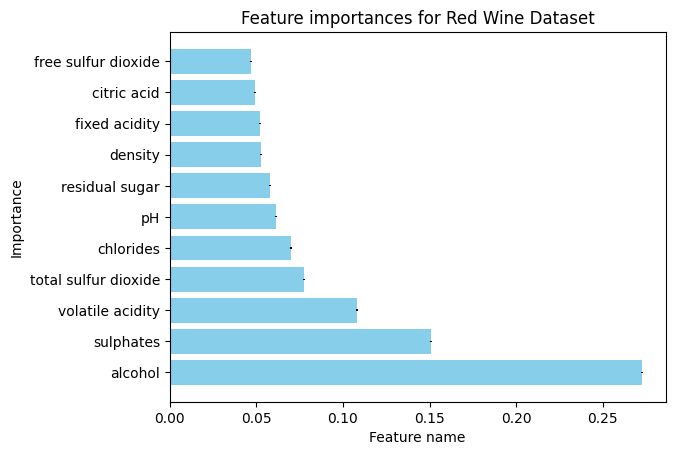

In [ ]:
# For random_forest, the parameter `feature_importances_` indicates the feature importance.
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = redWineParamDf.columns

# Print the feature ranking
print("Feature \t feature\n rank")
for f in range(X_train.shape[1]):
    print("  %d \t %s (%f)" % (f + 1, feature_names[min(indices[f], len(feature_names) - 1)], importances[min(indices[f], len(importances) - 1)]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances for Red Wine Dataset")
plt.barh(range(X_train.shape[1]), importances[indices], yerr=std[indices],color='skyblue', align="center")
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.xlabel("Feature name")
plt.ylabel("Importance")
plt.show()

40/40 [==============================] - 0s 1ms/step


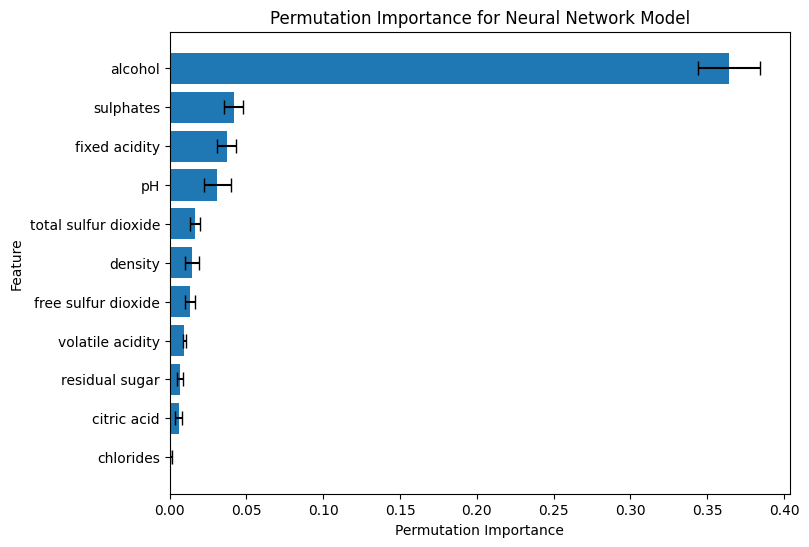

In [ ]:
# Coomparing the permutation importance for SMV with RBF kernel

perms = permutation_importance(NN_model, X_train, y_train, n_repeats=30,random_state=0,scoring='neg_mean_squared_error')
importance_index = perms.importances_mean.argsort()[::-1]
plt.figure(figsize=(8,6))
plt.barh(redWineParamDf.columns[importance_index], perms.importances_mean[importance_index],xerr=perms.importances_std[importance_index],capsize=5)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance for Neural Network Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

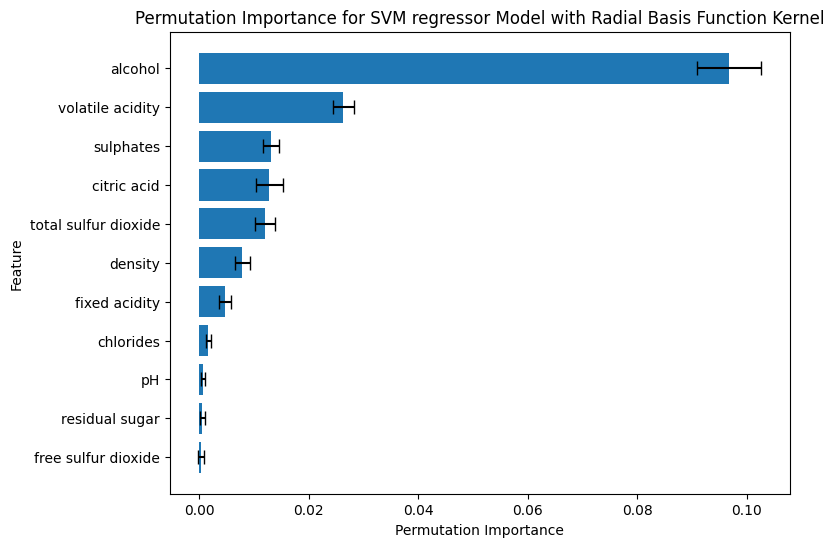

In [ ]:
# for neural networks plotting the permutation importance yields meaningful information.
perms = permutation_importance(svm_regressor, X_train, y_train, n_repeats=30,random_state=0,scoring='neg_mean_squared_error')
importance_index = perms.importances_mean.argsort()[::-1]
plt.figure(figsize=(8,6))
plt.barh(redWineParamDf.columns[importance_index], perms.importances_mean[importance_index],xerr=perms.importances_std[importance_index],capsize=5)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance for SVM regressor Model with Radial Basis Function Kernel')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

### e. Test the model for red with data from white and vice versa, and comment on whether the model for red wines is applicable to white wines and versa or not. [1]

In [ ]:
trainingParamDataDf = redWineNormParamDf
trainingTargetDataDf = redWineTargetDf
trainingDataClass = 'Red Wine'

testingParamDataDf = whiteWineNormParamDf
testingTargetDf = whiteWineTargetDf
testingDataClass = 'White Wine'

# Random Forest Classifier Training
X_train, y_train = trainingParamDataDf, trainingTargetDataDf
X_test, y_test = testingParamDataDf, testingTargetDf

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [20, 30, 50, 90],   #Number of trees
    'max_depth': [None, 10, 20, 30]         # max depth of each tree
}

# Create Random Forest classifier
random_forest = RFR(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
predictions = grid_search.predict(X_test)

rmse_RFR = np.sqrt(mean_squared_error(y_test, predictions))
nrmse_RFR = rmse_RFR / (np.max(y_test)-np.min(y_test))
print(f"training on {trainingDataClass}  Data and making predictions on {testingDataClass} Data, results are ")
print(f"Random Forest Model NRMSE on {testingDataClass} is {nrmse_RFR}")
print(f"R-squared score of this Random Forest regressor is {r2_score(y_test, np.round(predictions))}")  # rounding off as they are distinct numbers for the regressor instead of continous values.

Best parameters: {'max_depth': 10, 'n_estimators': 90}
training on Red Wine  Data and making predictions on White Wine Data, results are 
Random Forest Model NRMSE on White Wine is 0.13918662698398576
R-squared score of this Random Forest regressor is 0.01718041320845054


In [ ]:
testingParamDataDf = redWineNormParamDf
testingTargetDf = redWineTargetDf
testingDataClass = 'Red Wine'

trainingParamDataDf = whiteWineNormParamDf
trainingTargetDataDf = whiteWineTargetDf
trainingDataClass = 'White Wine'

# Random Forest Classifier Training
X_train, y_train = trainingParamDataDf, trainingTargetDataDf
X_test, y_test = testingParamDataDf, testingTargetDf

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [20, 30, 50, 90],   #Number of trees
    'max_depth': [None, 10, 20, 30]         # max depth of each tree
}

# Create Random Forest classifier
random_forest = RFR(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
predictions = grid_search.predict(X_test)

rmse_RFR = np.sqrt(mean_squared_error(y_test, predictions))
nrmse_RFR = rmse_RFR / (np.max(y_test)-np.min(y_test))
print(f"training on {trainingDataClass}  Data and making predictions on {testingDataClass} Data, results are ")
print(f"Random Forest Model NRMSE on {testingDataClass} is {nrmse_RFR}")
print(f"R-squared score of the Random Forest regressor is {r2_score(y_test, np.round(predictions))}")  # rounding off as they are distinct numbers for the regressor instead of continous values.

Best parameters: {'max_depth': 10, 'n_estimators': 90}
training on White Wine  Data and making predictions on Red Wine Data, results are 
Random Forest Model NRMSE on Red Wine is 0.15209950481960366
R-squared score of the Random Forest regressor is 0.02990418993508248


Observations
- White wine data seems to be more suited to predict the red wine quality levels based on the respective r squared scores for predicting the wine quality.  

## **2. Classification:**





### a. Download the data to predict Down syndrome in mice from https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression#. The prediction problem is to either predict the genotype (binary) using the gene expression variables from DYRK1A_N to CaNA_N.

In [ ]:
zip_url_2="https://archive.ics.uci.edu/static/public/342/mice+protein+expression.zip"
response = requests.get(zip_url_2)                            # get zip file
if response.status_code == 200:                             # if 200 OK message reply for the file download
    # Extract the zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        zip_file.extractall("extracted_files_2")
        print("Zip file extracted successfully")
else:
    print("Zip file download failed!! Abort procedures.")
    sys.exit()

extracted_files_2 = os.listdir("extracted_files_2")          #listing downloaded and extracted files
#print(extracted_files_2)
rawDataDf = pd.read_excel(f"extracted_files_2/{extracted_files_2[0]}")

Zip file extracted successfully


In [ ]:
# splitting the data into the target and parameter data
GenoClassParamDf = rawDataDf.drop(['MouseID','Genotype','Treatment','Behavior','class'],axis=1)
GenoClassTargetDf = rawDataDf['class']

### b. Explore, visualize, and pre-process the data as appropriate, including developing a strategy to deal with missing variables. You can choose to impute the variable. The recommended way is to use multivariate feature imputation (https://scikit-learn.org/stable/modules/impute.html) [1]

In [ ]:
print(GenoClassParamDf.info())
print(GenoClassParamDf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         1077 non-null   float64
 1   ITSN1_N          1077 non-null   float64
 2   BDNF_N           1077 non-null   float64
 3   NR1_N            1077 non-null   float64
 4   NR2A_N           1077 non-null   float64
 5   pAKT_N           1077 non-null   float64
 6   pBRAF_N          1077 non-null   float64
 7   pCAMKII_N        1077 non-null   float64
 8   pCREB_N          1077 non-null   float64
 9   pELK_N           1077 non-null   float64
 10  pERK_N           1077 non-null   float64
 11  pJNK_N           1077 non-null   float64
 12  PKCA_N           1077 non-null   float64
 13  pMEK_N           1077 non-null   float64
 14  pNR1_N           1077 non-null   float64
 15  pNR2A_N          1077 non-null   float64
 16  pNR2B_N          1077 non-null   float64
 17  pPKCAB_N      

In [ ]:
# CHecking for rows with null values prior to imputing the values
print(f"Null rows {GenoClassParamDf[GenoClassParamDf.isnull().any(axis=1)].shape[0]}")
print(f"NaN rows {GenoClassParamDf[GenoClassParamDf.isna().any(axis=1)].shape[0]}")

Null rows 528
NaN rows 528


In [ ]:
#imputing the data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=1000, random_state=0) #initialise the imputer as an iterative imputer which iteratively imputes the values
imp_GenoClassParamDf =  pd.DataFrame(imputer.fit_transform(GenoClassParamDf), columns=GenoClassParamDf.columns) # imputing data
if imp_GenoClassParamDf[imp_GenoClassParamDf.isnull().any(axis=1)].shape[0] == 0 :                        # when no empty values are there to fill
    print("imputation complete!")

imputation complete!


In [ ]:
# Checking for distinct values in the data corpus
for col in imp_GenoClassParamDf.columns.values: # For each column
    list_vals = pd.unique(imp_GenoClassParamDf[col])    # Create a list of unique values
    print(str(len(list_vals)) + ' \tunique values for '+col)
    if len(list_vals) < 10: # If the column has less than 10 unique values then print them
        list_str = ', '.join(map(str, list_vals))
        print('  These are: '+list_str)

1080 	unique values for DYRK1A_N
1079 	unique values for ITSN1_N
1080 	unique values for BDNF_N
1080 	unique values for NR1_N
1080 	unique values for NR2A_N
1079 	unique values for pAKT_N
1078 	unique values for pBRAF_N
1080 	unique values for pCAMKII_N
1080 	unique values for pCREB_N
1080 	unique values for pELK_N
1080 	unique values for pERK_N
1079 	unique values for pJNK_N
1080 	unique values for PKCA_N
1080 	unique values for pMEK_N
1080 	unique values for pNR1_N
1080 	unique values for pNR2A_N
1080 	unique values for pNR2B_N
1080 	unique values for pPKCAB_N
1080 	unique values for pRSK_N
1080 	unique values for AKT_N
1080 	unique values for BRAF_N
1080 	unique values for CAMKII_N
1076 	unique values for CREB_N
1080 	unique values for ELK_N
1080 	unique values for ERK_N
1080 	unique values for GSK3B_N
1080 	unique values for JNK_N
1079 	unique values for MEK_N
1078 	unique values for TRKA_N
1077 	unique values for RSK_N
1080 	unique values for APP_N
1080 	unique values for Bcatenin

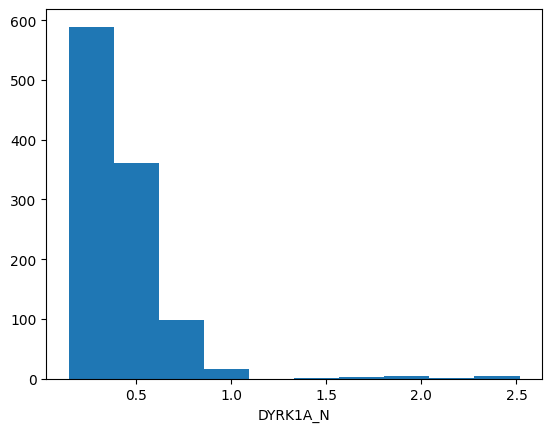

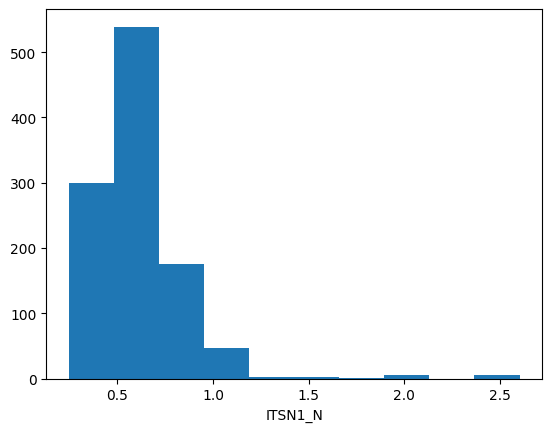

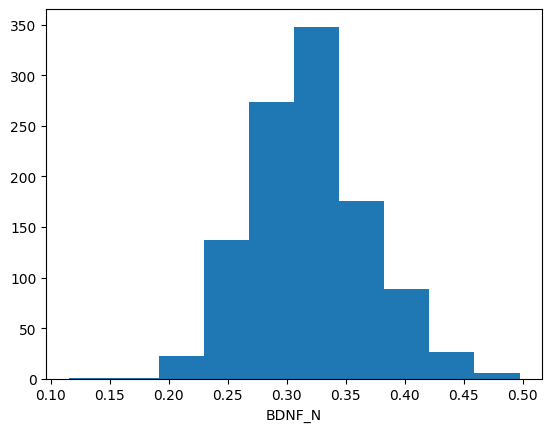

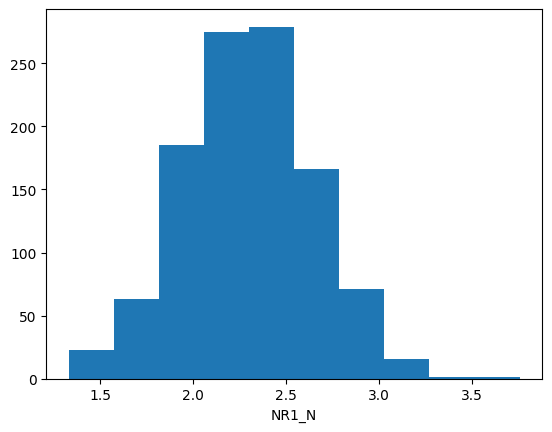

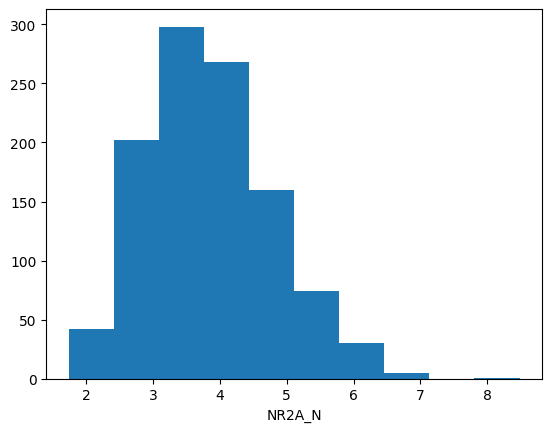

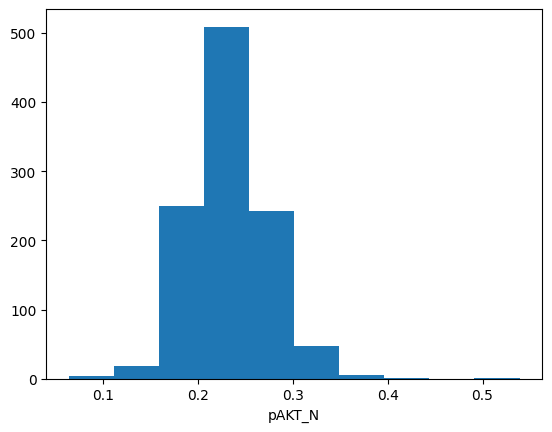

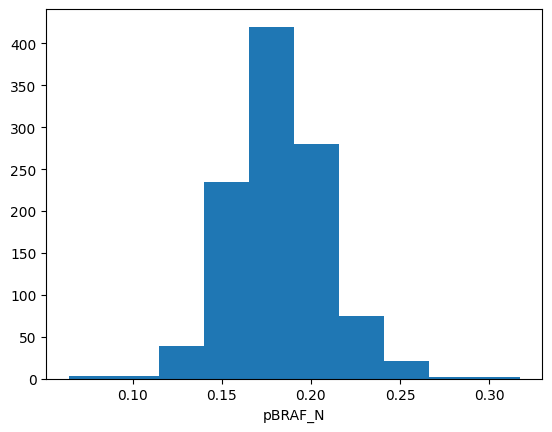

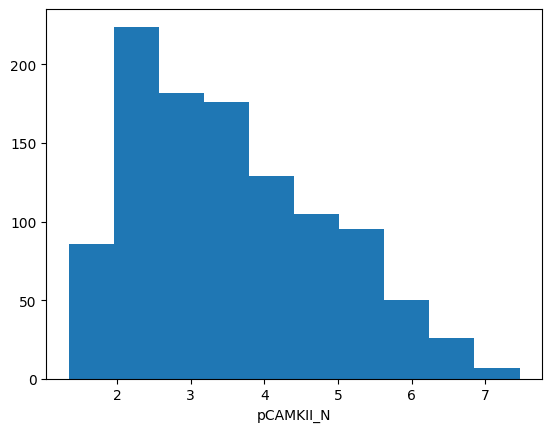

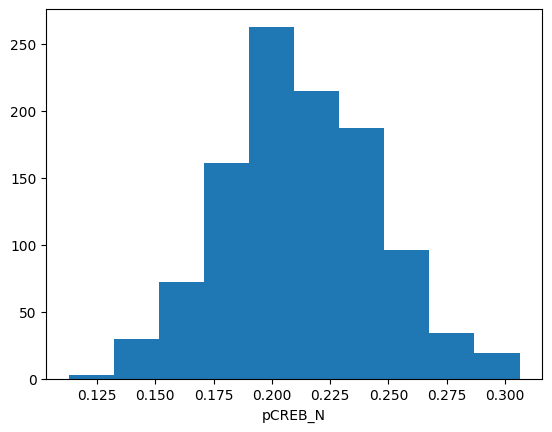

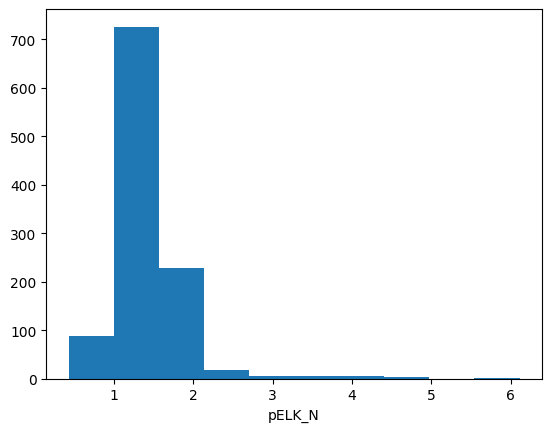

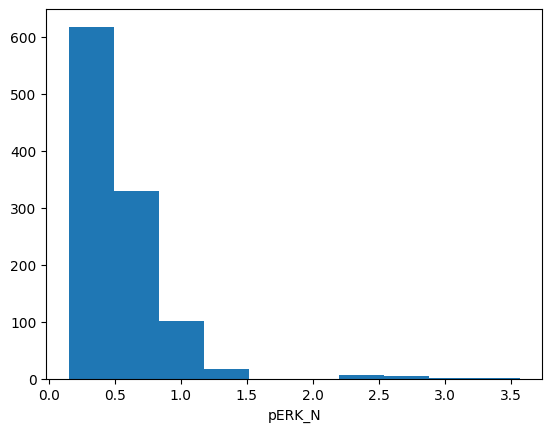

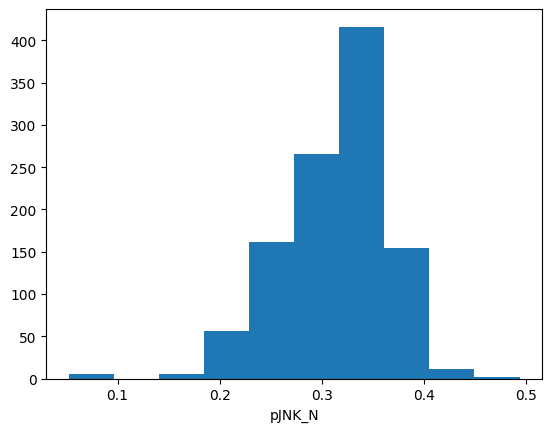

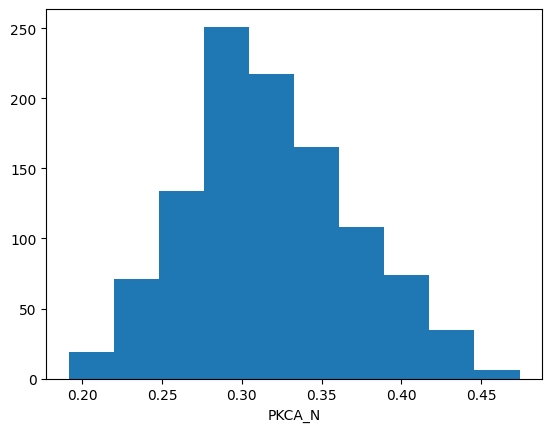

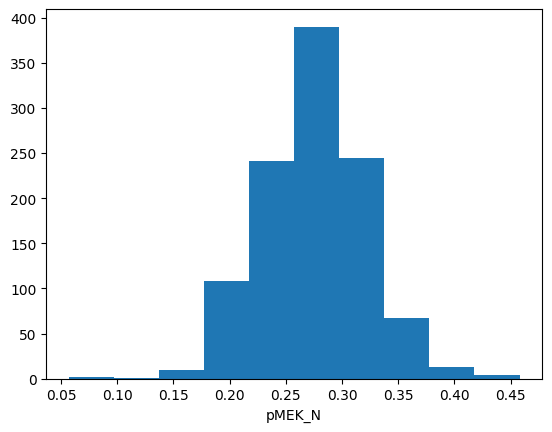

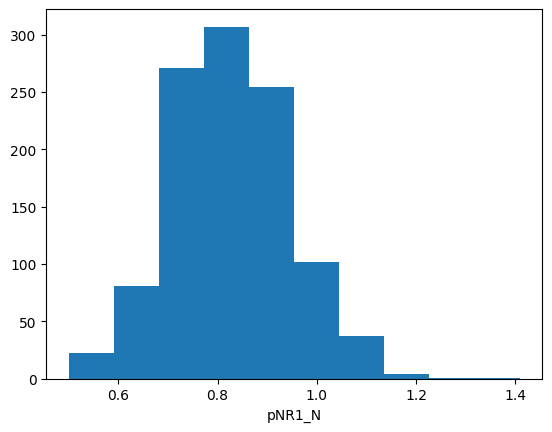

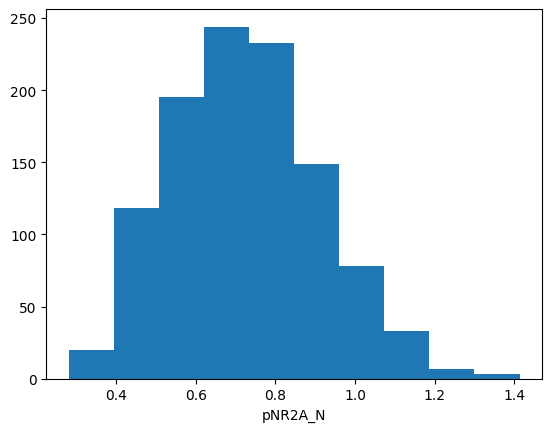

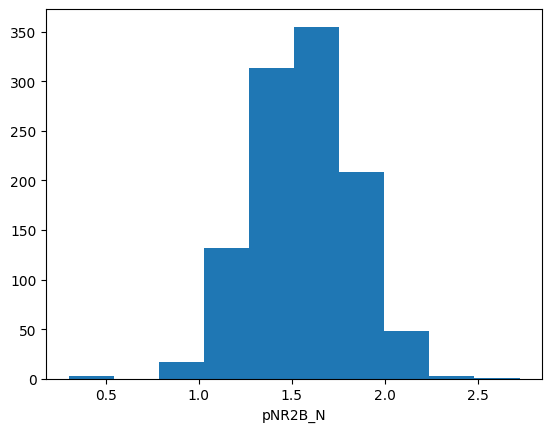

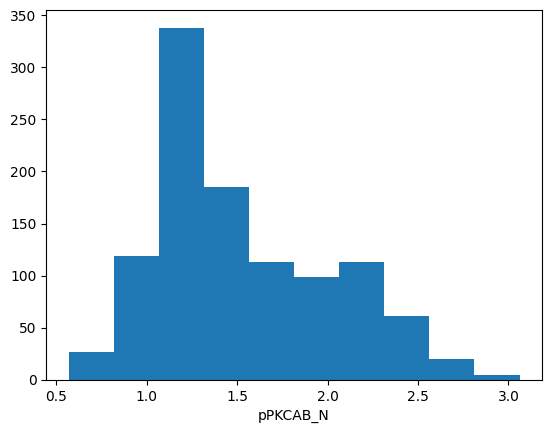

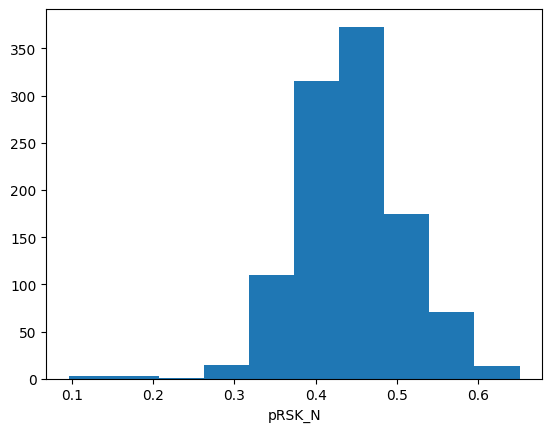

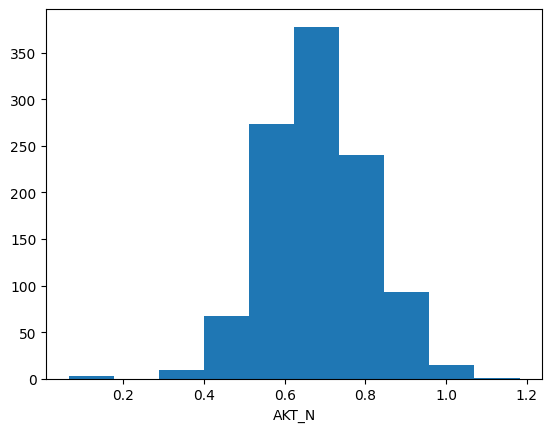

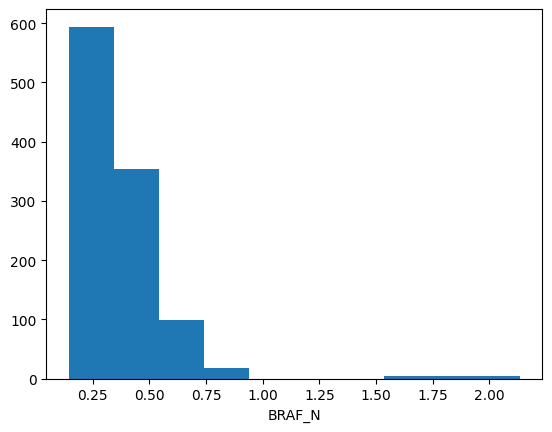

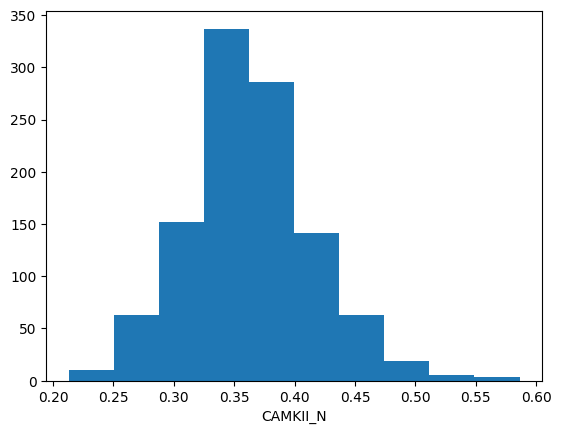

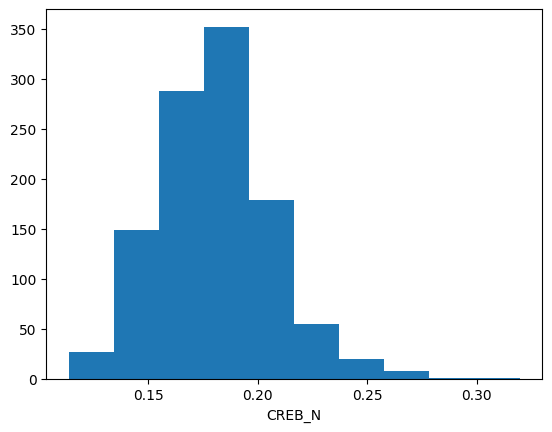

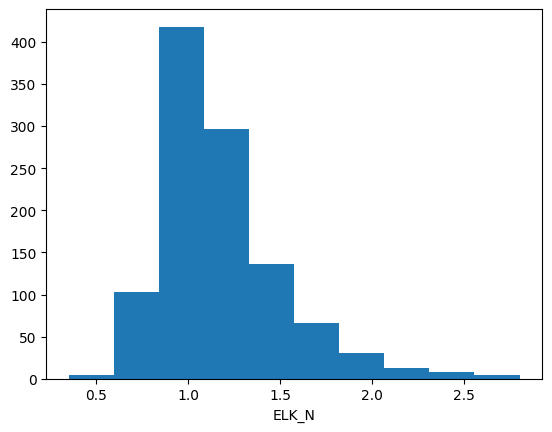

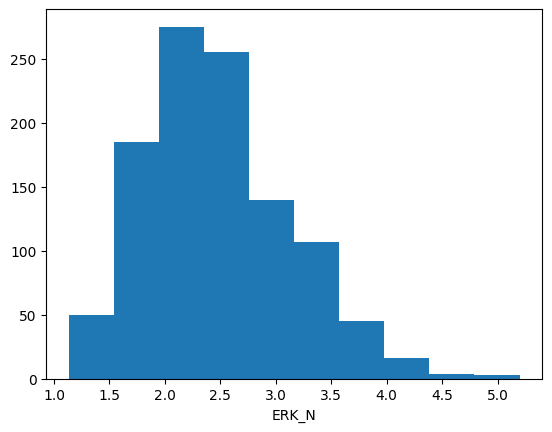

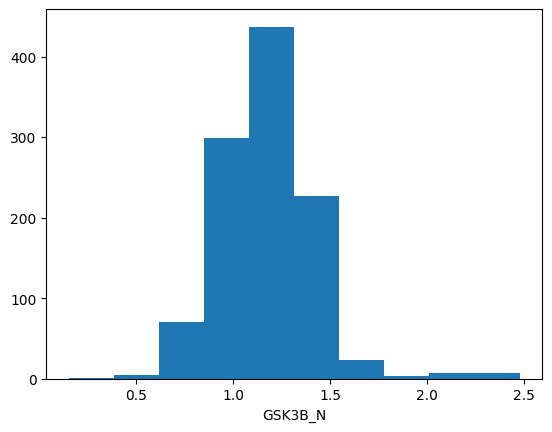

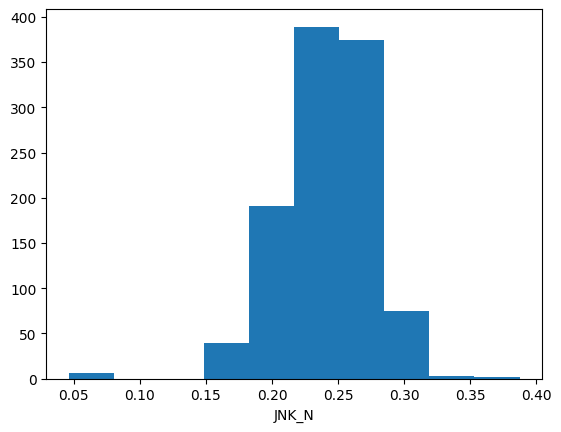

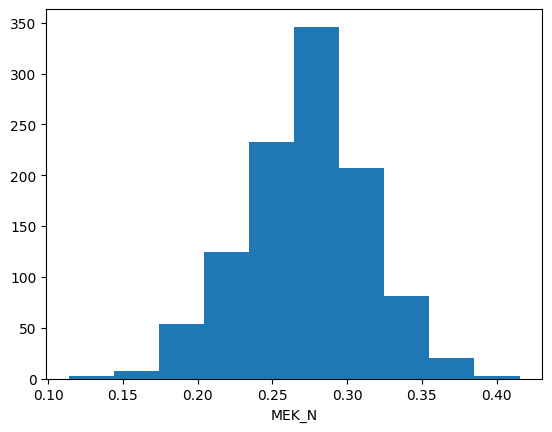

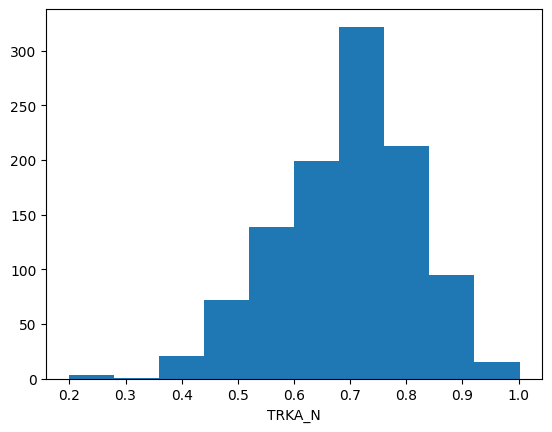

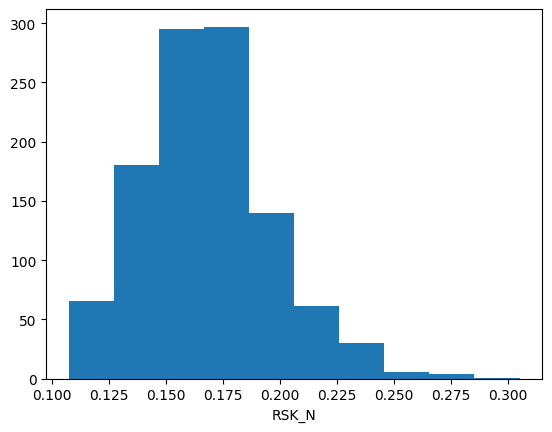

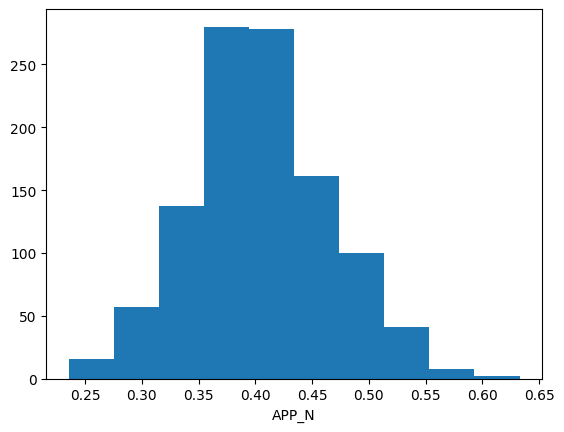

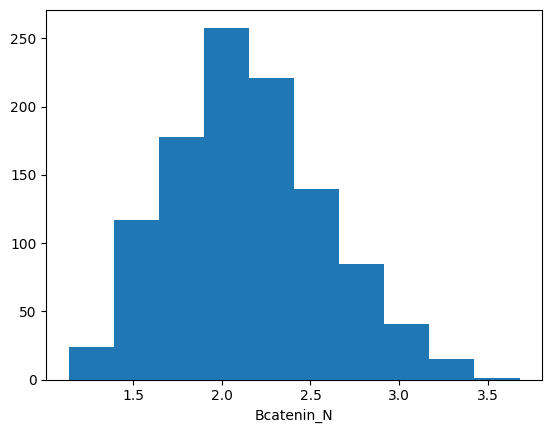

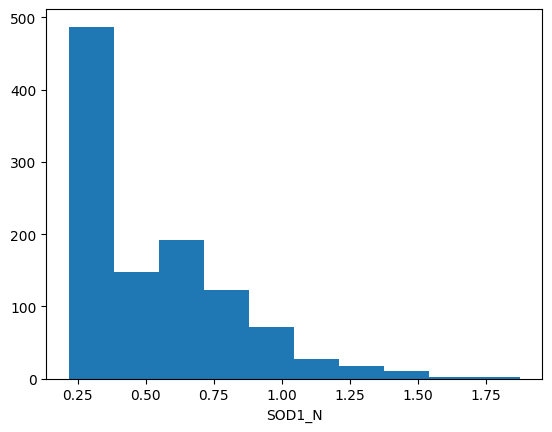

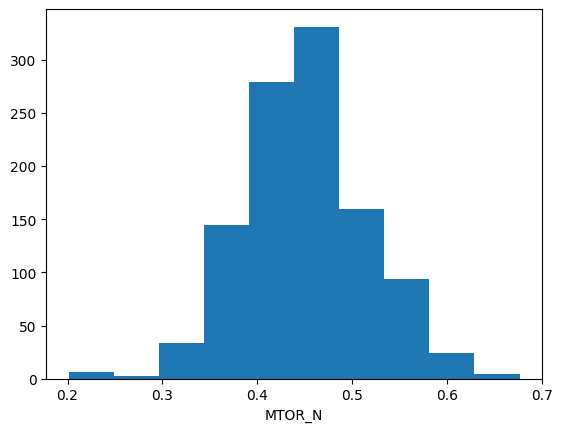

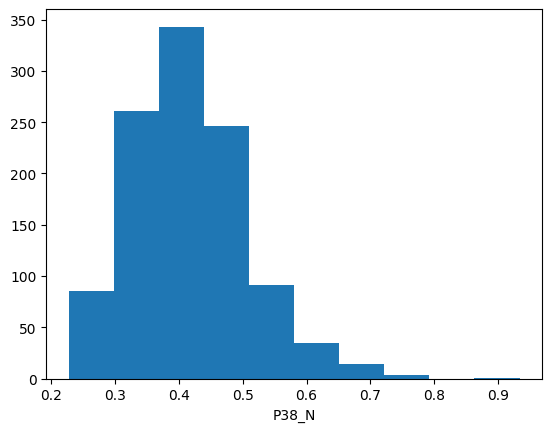

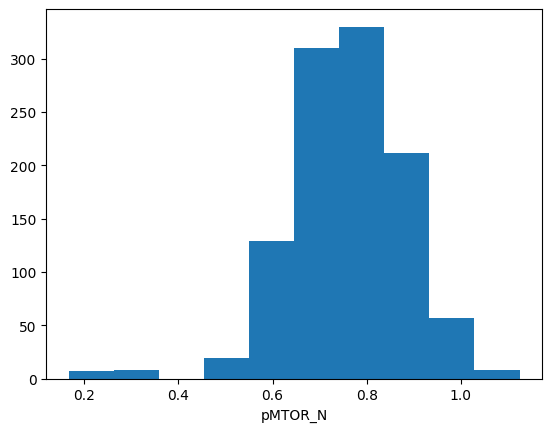

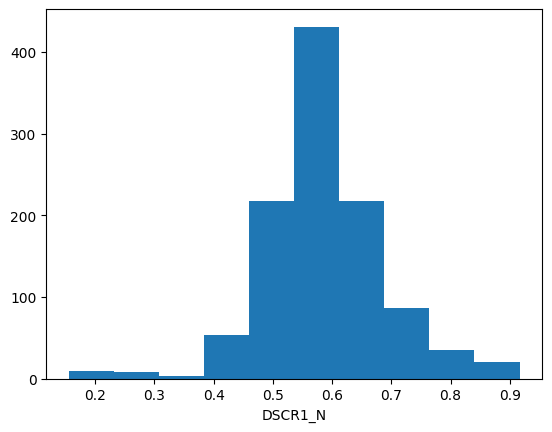

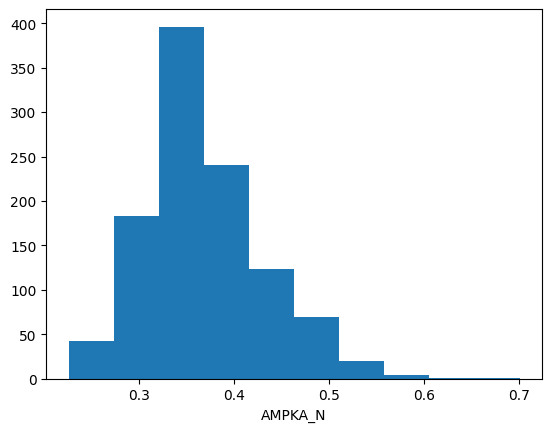

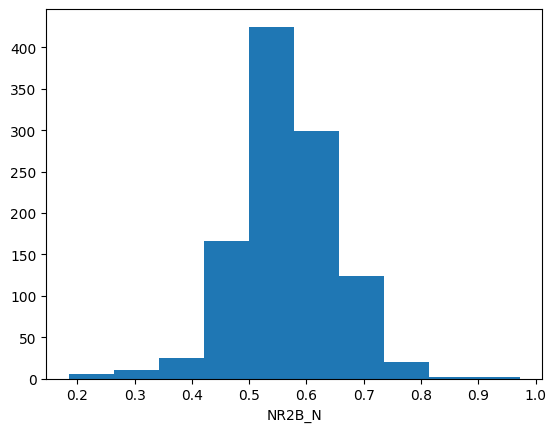

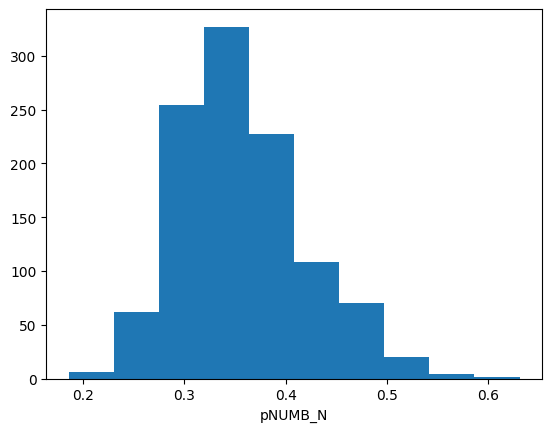

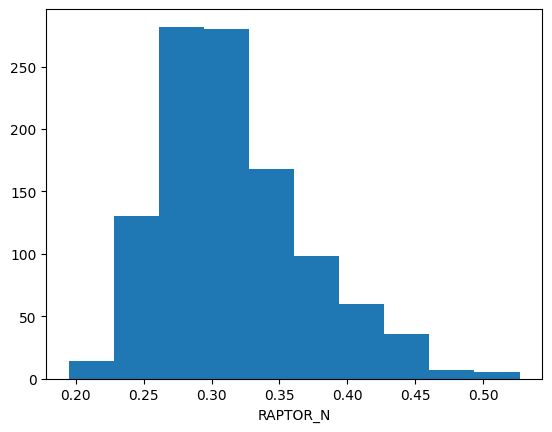

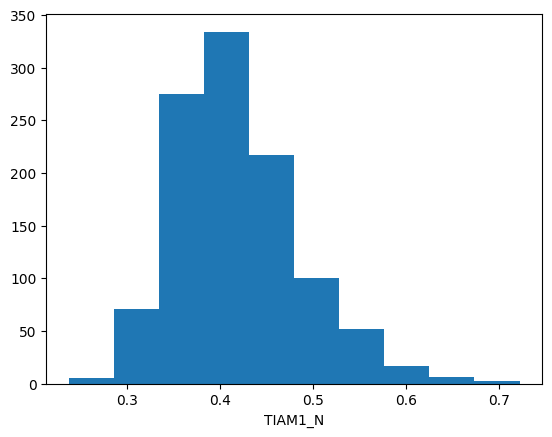

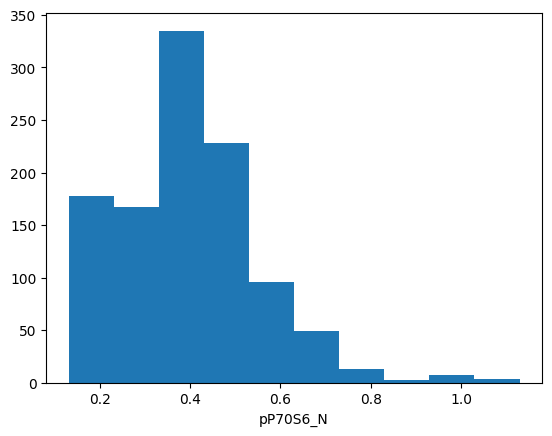

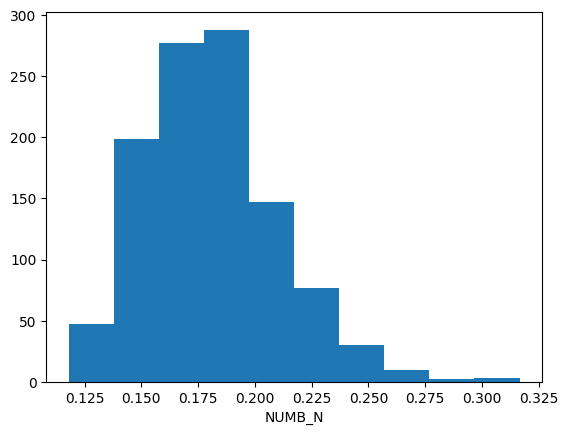

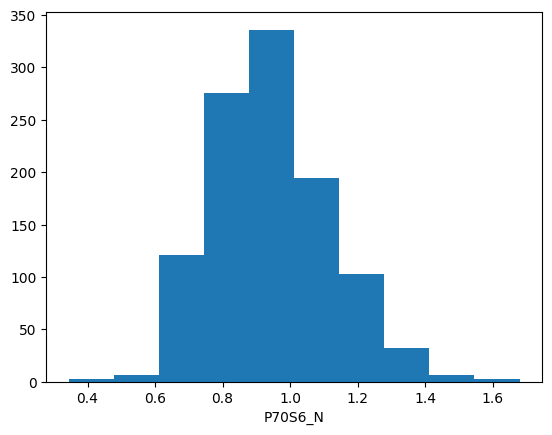

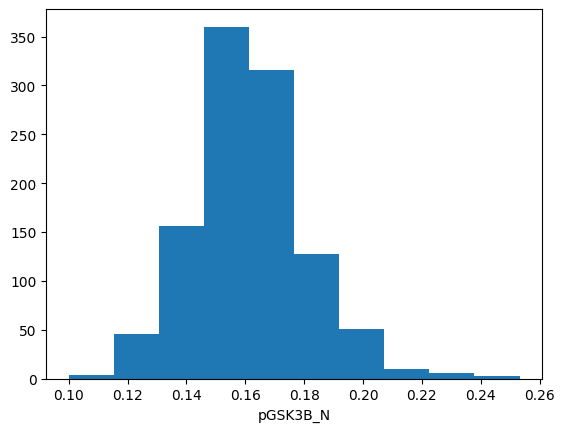

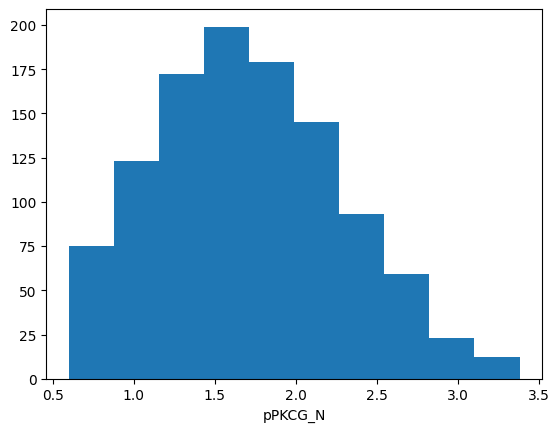

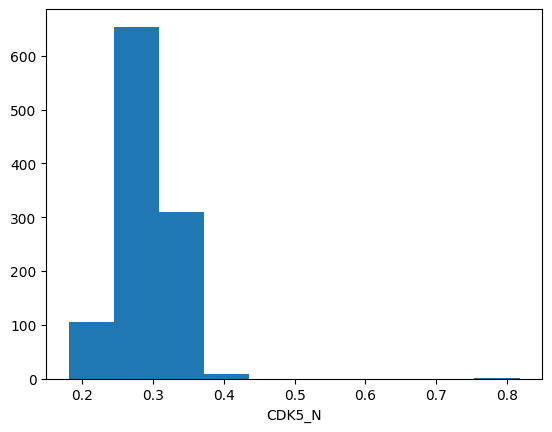

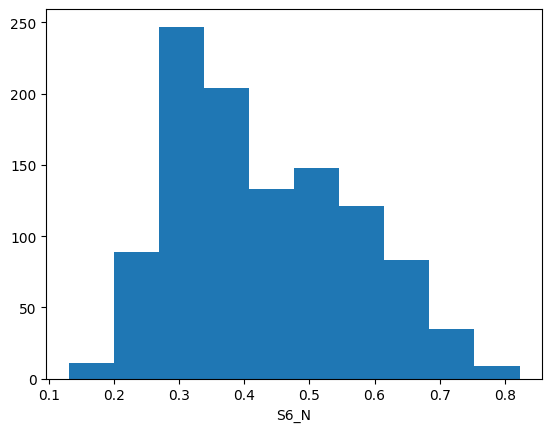

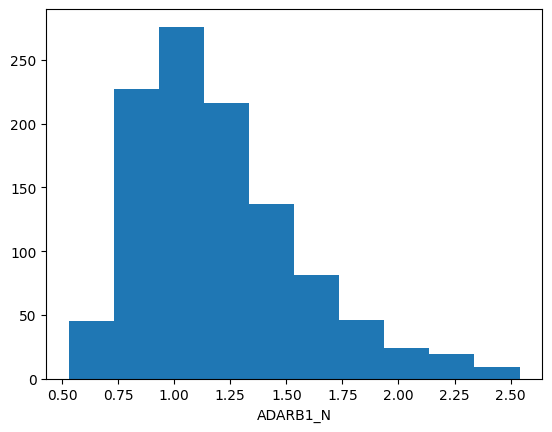

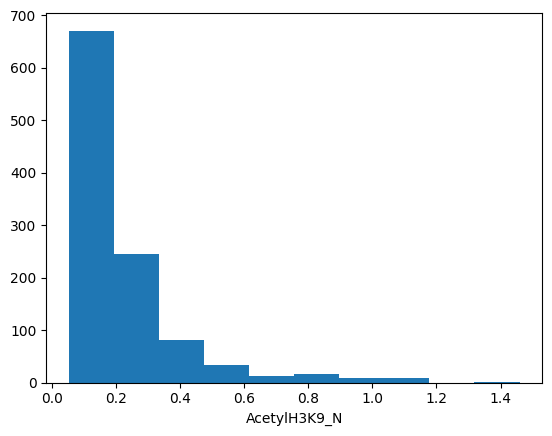

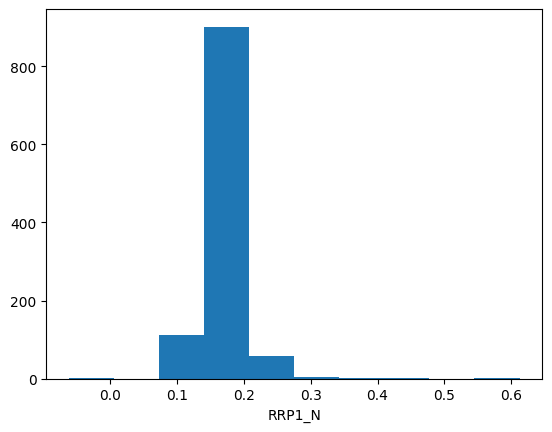

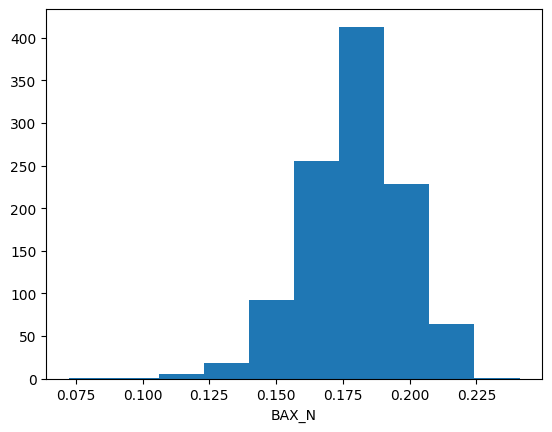

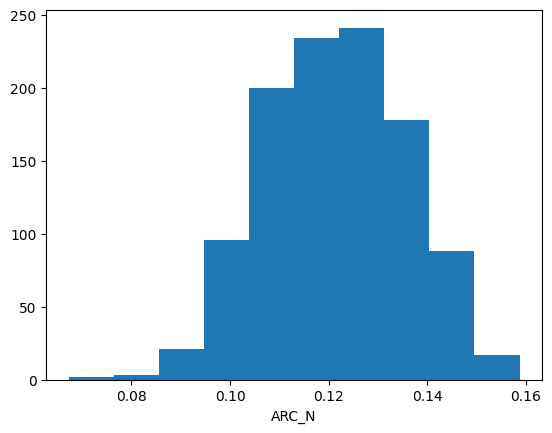

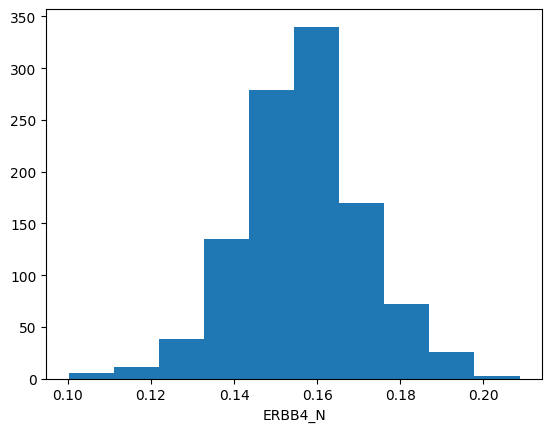

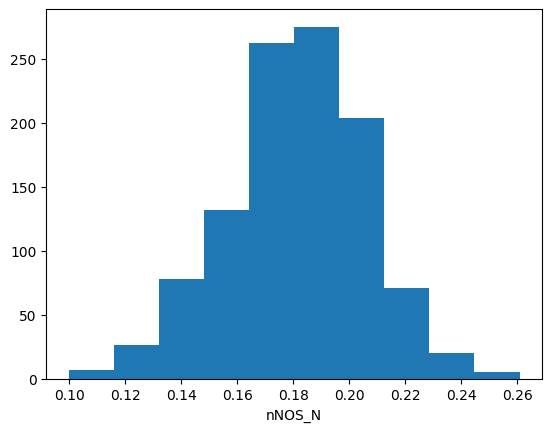

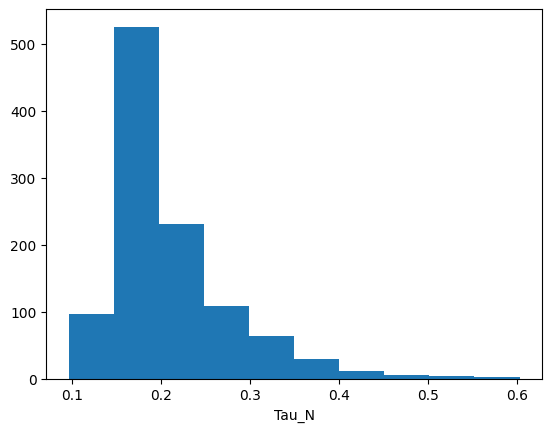

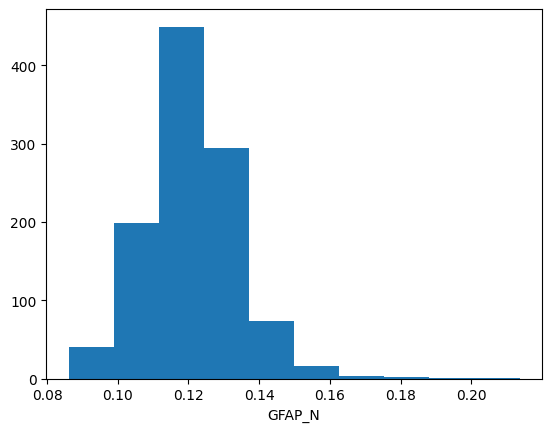

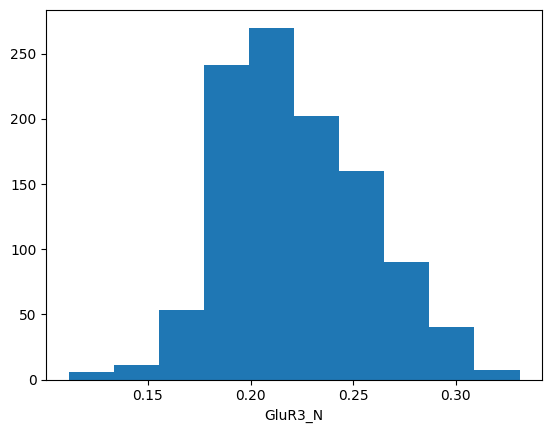

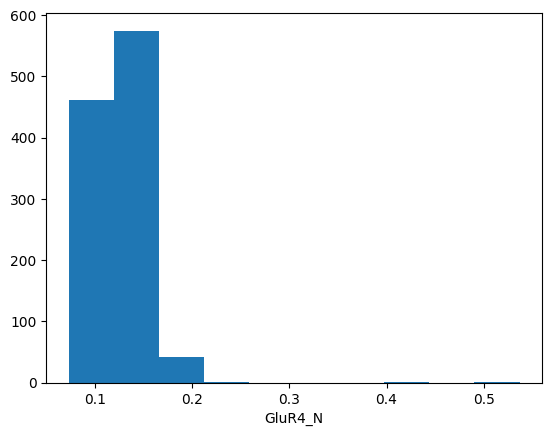

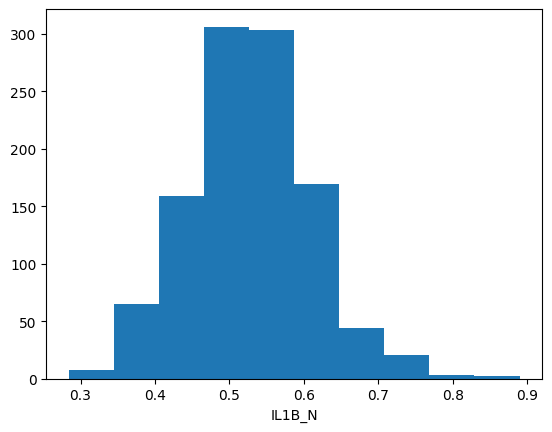

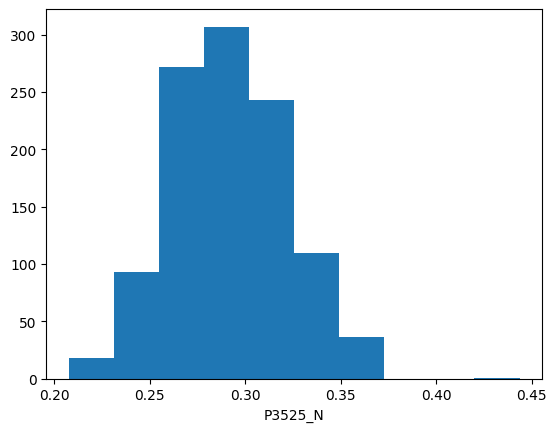

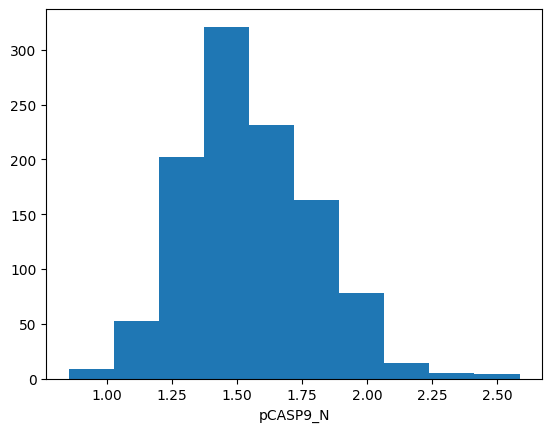

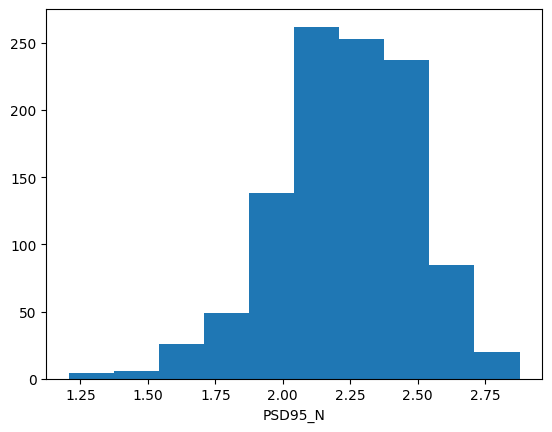

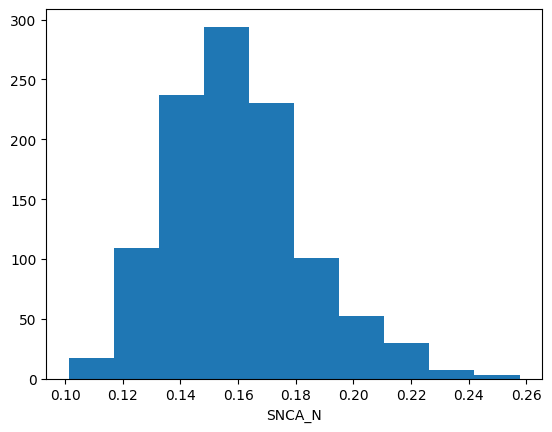

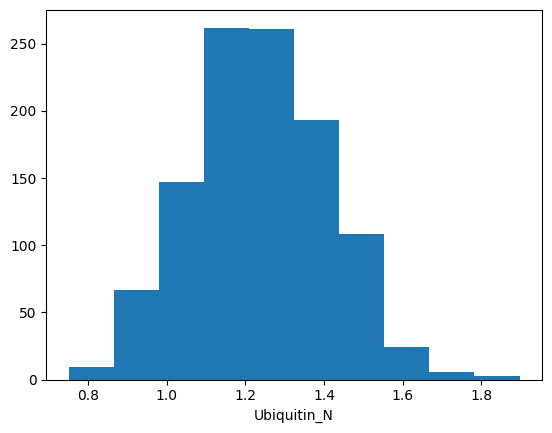

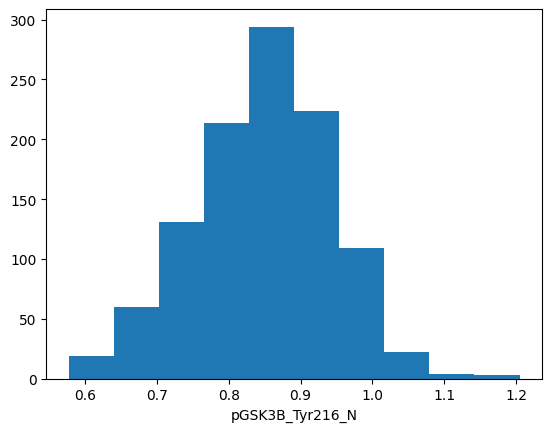

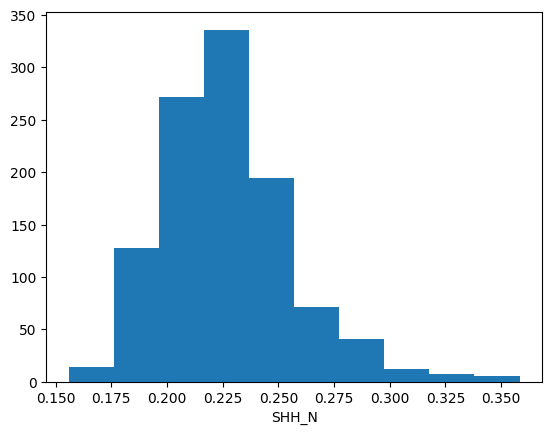

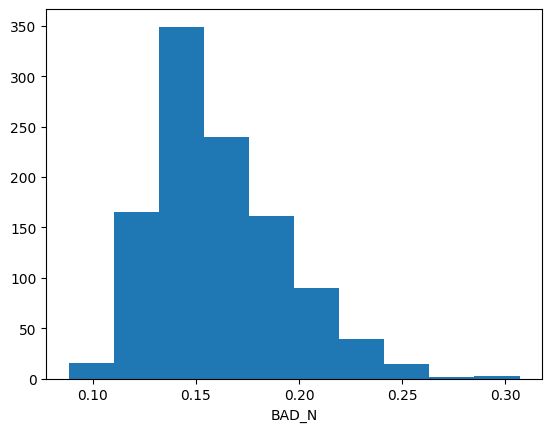

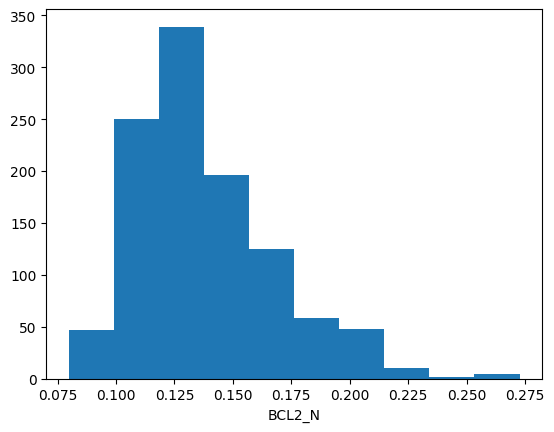

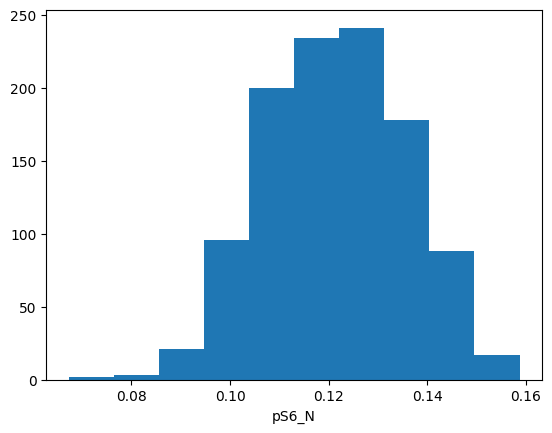

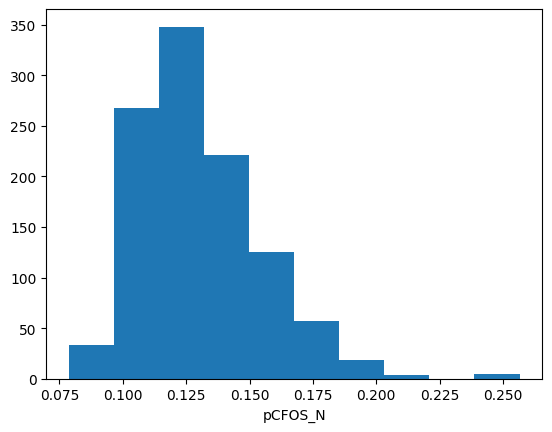

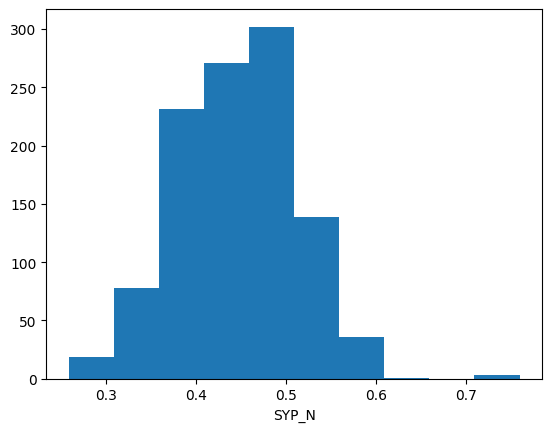

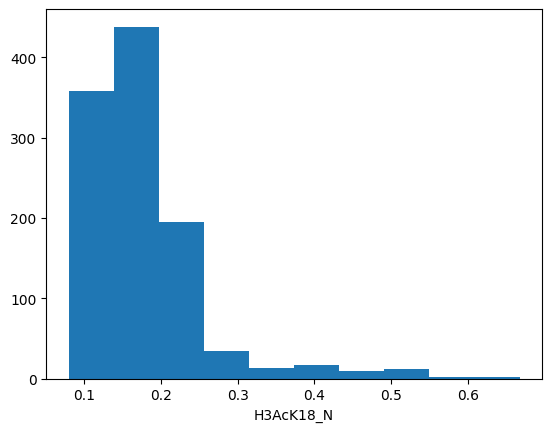

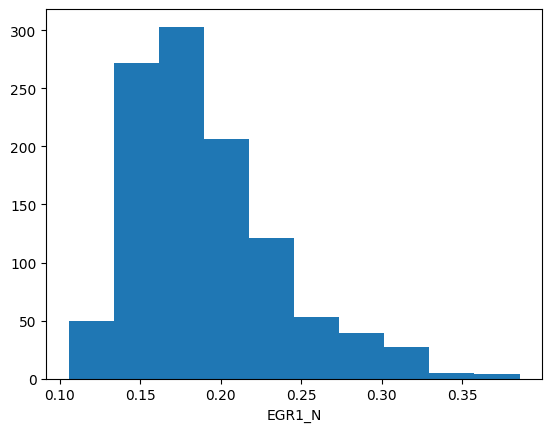

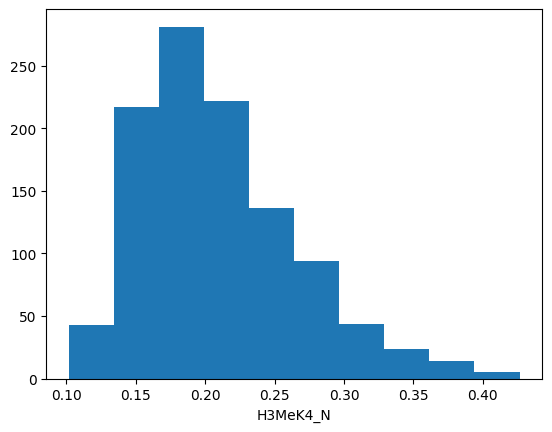

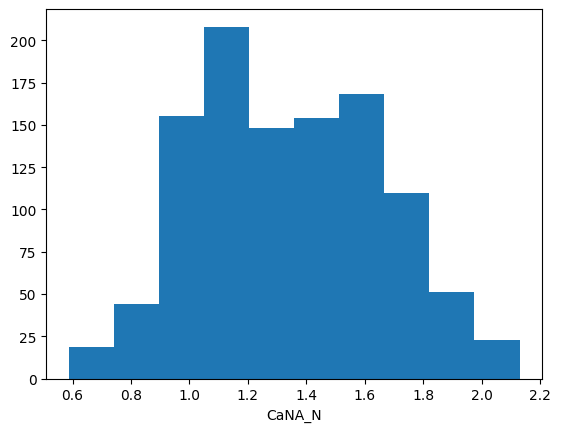

In [ ]:
#plotting histogram plots for the columns
for col in imp_GenoClassParamDf.columns.values:
  if (imp_GenoClassParamDf[col].dtypes == 'int64') | (imp_GenoClassParamDf[col].dtypes == 'float64'):
    plt.hist(imp_GenoClassParamDf[col],10 if len(pd.unique(imp_GenoClassParamDf[col]))>20 else len(pd.unique(imp_GenoClassParamDf[col])))
    plt.xlabel(col)
    plt.show()

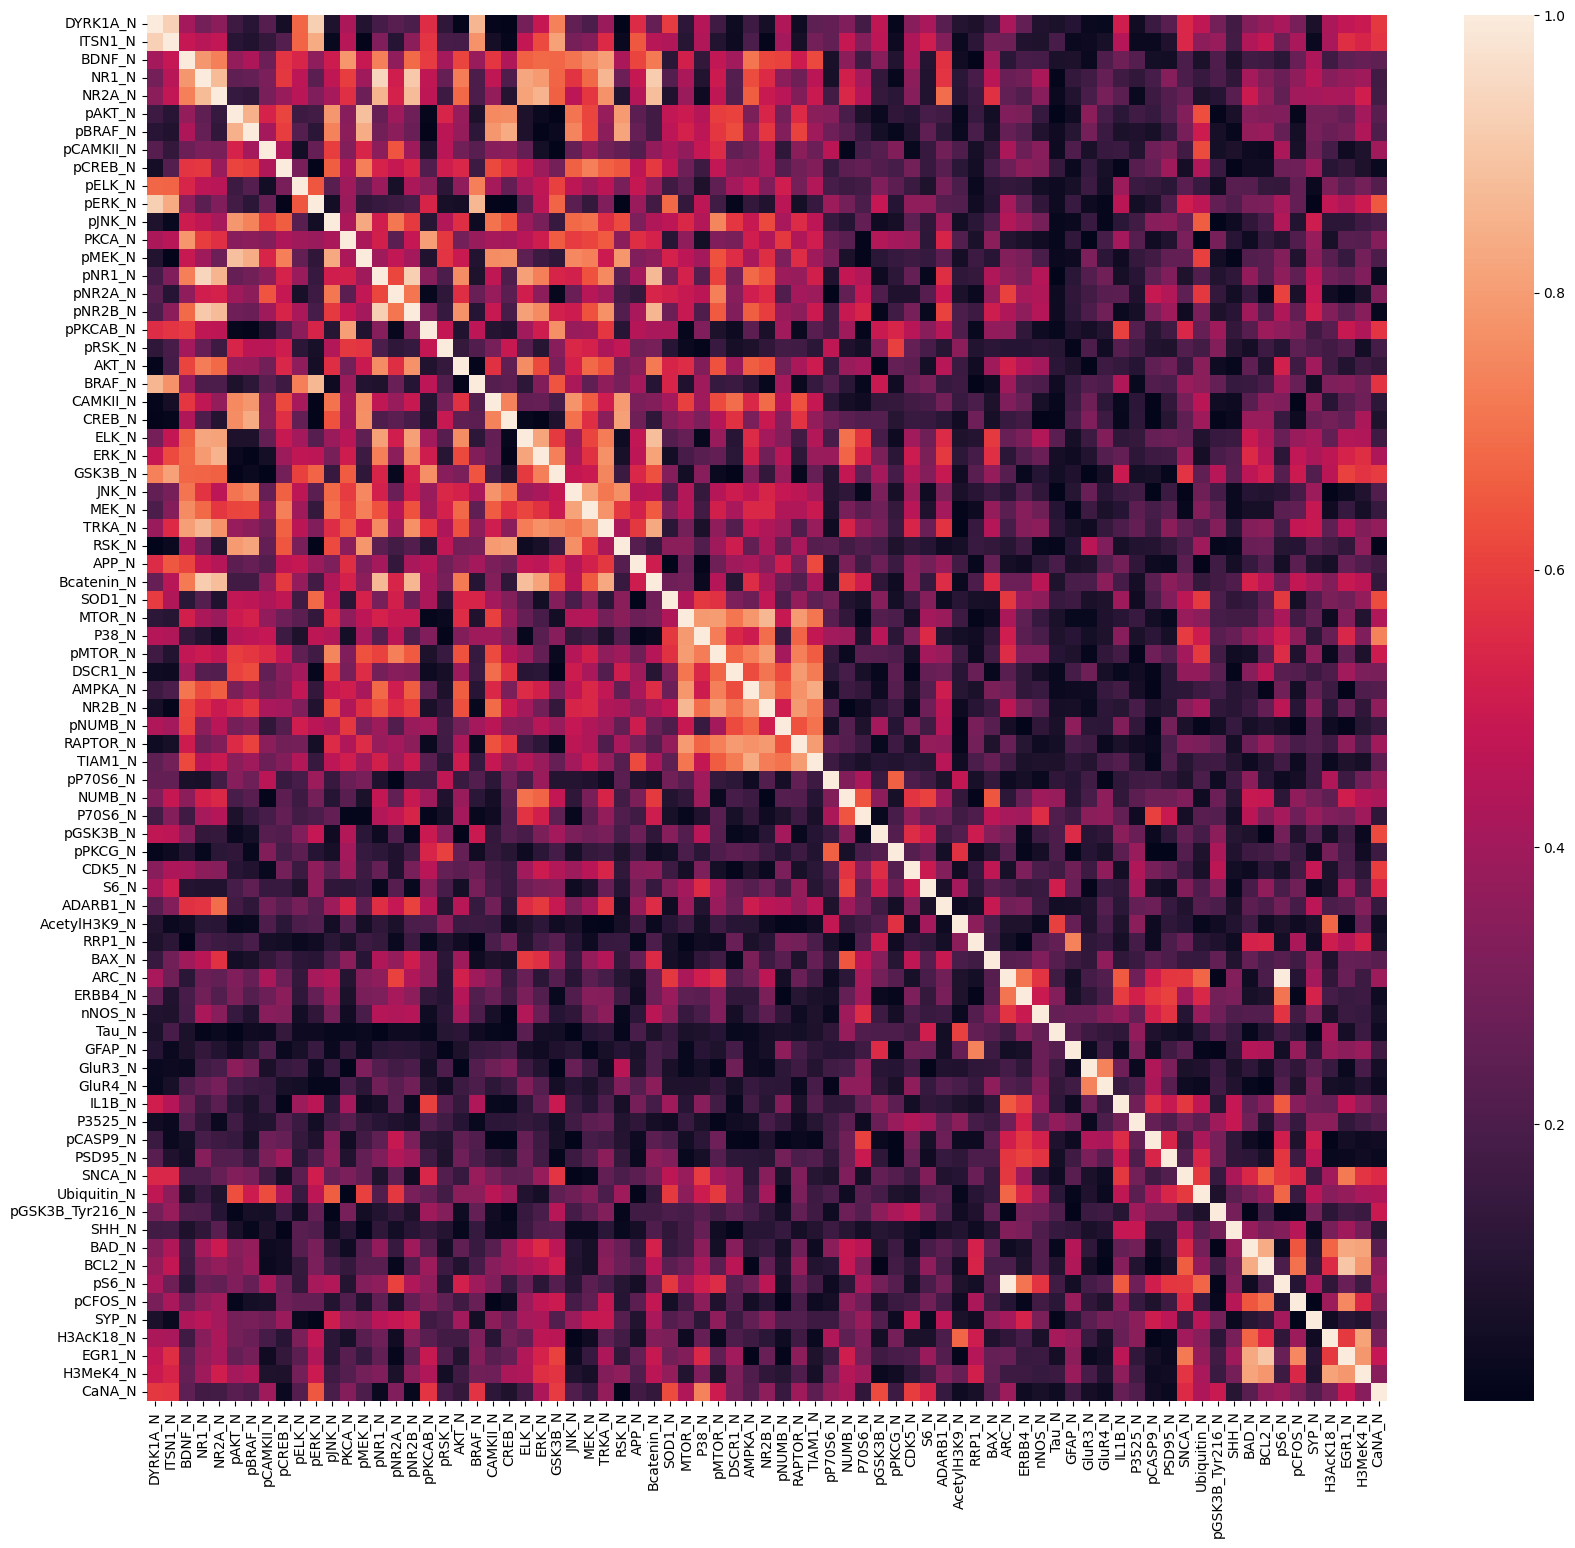

In [ ]:
#plotting the correlation between the different features available in the data set.
redCorrMatrix = imp_GenoClassParamDf.corr(method='spearman') # Use spearman for non-linear
fig, ax = plt.subplots(figsize=(20,18))
sns.heatmap(abs(redCorrMatrix), annot=False) # Show absolute value
plt.show()

### c. Train, validate varying at least one hyperparameter, and test at least two types of models: [2]

    i. Random forest

    ii. Support vector classification using RBF kernel

    iii. Neural network with single hidden layer (output layer should be have softmax activation)


#### ii. SVM with RBF kernel Classifier training and hyper parameter tuning

In [ ]:
# SVM with RBF kernel Classifier training and hyper parameter tuning
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imp_GenoClassParamDf, GenoClassTargetDf, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {'C': [0.1, 1, 2],
              'gamma': [0.001, 0.01, 0.1]}

# Create SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Best parameters: {'C': 2, 'gamma': 0.1}
Accuracy: 0.9583333333333334
Classification Report:
              precision    recall  f1-score   support

      c-CS-m       0.89      1.00      0.94        32
      c-CS-s       1.00      0.85      0.92        26
      c-SC-m       0.93      1.00      0.96        27
      c-SC-s       1.00      0.97      0.99        34
      t-CS-m       1.00      0.89      0.94        19
      t-CS-s       0.92      1.00      0.96        22
      t-SC-m       1.00      0.92      0.96        25
      t-SC-s       0.97      1.00      0.98        31

    accuracy                           0.96       216
   macro avg       0.96      0.95      0.96       216
weighted avg       0.96      0.96      0.96       216



#### i. Random Forest Classifier

In [ ]:
# Random Forest Classifier Training
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imp_GenoClassParamDf, GenoClassTargetDf, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [20, 30, 50],   #Number of trees
    'max_depth': [None, 10, 20, 30]         # max depth of each tree
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Best parameters: {'max_depth': 10, 'n_estimators': 50}
Accuracy: 0.9907407407407407
Classification Report:
              precision    recall  f1-score   support

      c-CS-m       0.97      1.00      0.98        32
      c-CS-s       0.96      0.96      0.96        26
      c-SC-m       1.00      1.00      1.00        27
      c-SC-s       1.00      1.00      1.00        34
      t-CS-m       1.00      0.95      0.97        19
      t-CS-s       1.00      1.00      1.00        22
      t-SC-m       1.00      1.00      1.00        25
      t-SC-s       1.00      1.00      1.00        31

    accuracy                           0.99       216
   macro avg       0.99      0.99      0.99       216
weighted avg       0.99      0.99      0.99       216



#### iii. Neural Network based classifier with single hidden layer (output layer should be have softmax activation)

In [ ]:
# hyper parameter initialization for tuning to get optimal model
hidden_units = [ 20, 50, 100]
epochs = [ 50, 100, 200]
batch_size = [32, 64]
activation_fun =['relu','linear']

#coding the output values to 0-7 range to calculate accuracy easily
output_dict = { GenoClassTargetDf.unique()[value] : value for value in range(len(GenoClassTargetDf.unique())) }  # mapping dictionary storing the label vs index as a dictionary
for key in output_dict.keys() :
    GenoClassTargetDf.replace({key:output_dict[key]}, inplace=True)

#train, validate, test splits
GenoClassTargetDf_encoded = pd.get_dummies(GenoClassTargetDf)
X_train, X_test, y_train, y_test = train_test_split(imp_GenoClassParamDf, GenoClassTargetDf_encoded, test_size=0.2, random_state=42)
X_train_nn_split, X_validate, y_train_nn_split, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# initialising worse case scenario values to start the optimization of model results
model_loss = 100
model_accuracy = 0

#iterating over the hyper parameters to perform hyper parameter tuning and save optimal model as per given hyperparameters
for hidden_unit in hidden_units:
    for epoch in epochs:
        for batch_length in batch_size:
            for activation_fn in activation_fun:
                #creating NN model with one hidden layer and 8 classes based softmax activated output layer
                model = tf.keras.Sequential([
                                            tf.keras.layers.Dense(units=hidden_unit, activation=activation_fn, input_shape=(imp_GenoClassParamDf.shape[1],)),
                                            tf.keras.layers.Dense(GenoClassTargetDf.unique().shape[0], activation='softmax')  # Output layer with softmax activation
                                            ])
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                # fitting the training parameters to the training targets
                model.fit(X_train_nn_split, y_train_nn_split, epochs=epoch, batch_size=batch_length, validation_split=0.1,verbose=0)

                #evaluating the performance of the model against the validation data
                loss, accuracy = model.evaluate(X_validate, y_validate)
                #storing the optimal model
                if model_accuracy < accuracy and model_loss > loss :
                    model.save("optimalNnClassifier.keras")
                else:
                    break

6/6 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9884


In [37]:
best_nn_model = tf.keras.models.load_model("optimalNnClassifier.keras")

# Make predictions on the test set using the best model
y_pred = best_nn_model.predict(X_test)

y_pred_index = np.argmax(y_pred, axis=1)
y_true_index = y_test.idxmax(axis=1).values

# Calculate accuracy
accuracy = accuracy_score(y_true_index, y_pred_index)
print("Accuracy:", accuracy)

7/7 [==============================] - 0s 2ms/step
Accuracy: 0.9398148148148148


### d. See if removing some features systematically will improve your models using recursive feature elimination https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). [1]

In [ ]:
from sklearn.feature_selection import RFECV

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imp_GenoClassParamDf, GenoClassTargetDf, test_size=0.2, random_state=42)

# Create a base classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=42)

# Create RFECV object
rfecv = estimator=RFECV(estimator=rf_classifier, cv=3)

# Train the RFECV grid search object
rfecv.fit(X_train, y_train)

# Evaluate the model
y_pred = rfecv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

#Classification report generation
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Test Accuracy: 0.9953703703703703
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      1.00      1.00        27
           2       1.00      0.96      0.98        26
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        31

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



## **3. Practice using pre-trained neural networks to extract domain-specific features for new tasks.**






### a. Read the pytorch tutorial to use a pre-trained “ConvNet as fixed feature extractor” from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and you can ignore “finetuning the ConvNet”. Test this code out to see if it runs properly in your environment after eliminating code blocks that you do not need. [1]

In [ ]:
#ref : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# License: BSD
# Author: Sasank Chilamkurthy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# -> modified section to extract the data from the zip file
dataset_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
response = requests.get(dataset_url)                            # get zip file
if response.status_code == 200:                             # if 200 OK message reply for the file download
    # Extract the zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        zip_file.extractall("data")
        print("Zip file extracted successfully")
else:
    print("Zip file download failed!! Abort procedures.")
    sys.exit()

extracted_files = os.listdir("data")          #listing downloaded and extracted files
print(extracted_files)
# < -  modification end

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Zip file extracted successfully
['hymenoptera_data']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


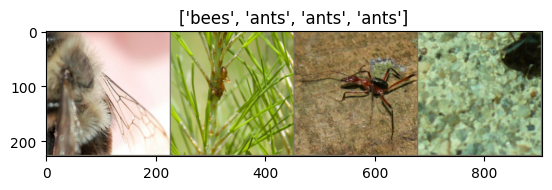

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6631 Acc: 0.6352
val Loss: 0.2497 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4888 Acc: 0.7541
val Loss: 0.2568 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5912 Acc: 0.7787
val Loss: 0.1951 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5383 Acc: 0.8115
val Loss: 0.2977 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5073 Acc: 0.8074
val Loss: 0.1826 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3861 Acc: 0.8402
val Loss: 0.3148 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4860 Acc: 0.7910
val Loss: 0.2352 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3699 Acc: 0.8402
val Loss: 0.2183 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2984 Acc: 0.8648
val Loss: 0.2073 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3839 Acc: 0.8402
val Loss: 0.2138 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3411 Acc: 0.8361
val Loss: 0.2005 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3231 Acc: 0.8484
val Loss: 0.2093 Acc: 0.9346

Ep

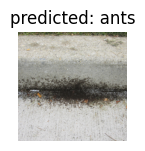

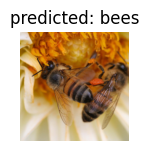

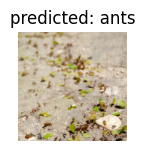

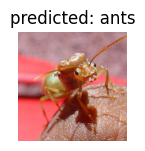

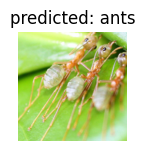

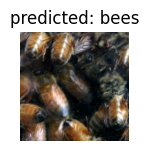

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### b. Write a function that outputs ResNet18 features for a given input image. Extract features for training images (in image_datasets['train']). You should get an Nx512 dimensional array. [1]

In [34]:
# Remove the last fully connected layer to obtain features
features_model = torch.nn.Sequential(*list(model_conv.children())[:-1])

# Set the model to evaluation mode
features_model.eval()

# Create a DataLoader for the training images
dataloader = DataLoader(image_datasets['train'], batch_size=32, shuffle=False)

# List to store the extracted features
features_list = []

# Iterate over the training images and extract features
for inputs, _ in dataloader:
    # Forward pass the input images through the features model
    with torch.no_grad():
        features = features_model(inputs)

    # Flatten the features and append to the features list
    features_list.append(features.view(features.size(0), -1))

# Concatenate the features from all batches into a single tensor
features_tensor = torch.cat(features_list, dim=0)
features_tensor.numpy().shape

(244, 512)

### c. Compare RBF kernel SVM (do grid search on kernel width and regularization) and random forest (do grid search on max depth and number of trees). Test the final model on test data and show the results -- accuracy and F1 score. [1]

## **4. Deploy one model from part 1 on a local webserver with a web frontend (e.g. using streamlit). Add some GUI elements, such as sliders for acidity, citrus etc. [2] Most of this should be in the video demo.**

In [38]:
#ref : https://discuss.streamlit.io/t/how-to-launch-streamlit-app-from-google-colab-notebook/42399
!pip install -q streamlit
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.511s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
%%writefile app.py

import numpy as np
import pandas as pd
import streamlit as st
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import pickle5 as pickle

# Load the MinMaxScaler from a file (replace with your loading logic)
with open('scalerRedWine.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define a function to scale user input based on weights
def scale_input(data):
    return scaler.transform(data)

# Load your trained model (replace with your model loading logic)
with open('RFR_redWinePredictor.pkl', 'rb') as MLmodel:
    model = pickle.load(MLmodel)

cols=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

def main():
    st.title("Wine Quality Predictor")
    html_temp = """
    <div style="background:#025246 ;padding:10px">
    <h2 style="color:white;text-align:center;">Wine Quality predictor App </h2>
    </div>
    """
    st.markdown(html_temp, unsafe_allow_html = True)

    fixed_acidity = st.slider('Acidity of the wine?', 4.6, 15.9)
    volatile_acidity = st.slider('Volatile acidity', 0.12,1.58,0.65, 0.05)
    citric_acid = st.slider('Citric Acid Content',0.0,1.0,0.6,0.05)
    residual_sugar = st.slider('Residual sugar content', 0.9,15.5)
    chlorides = st.slider('Chloride content',0.012,0.611,0.444,0.001)
    free_sulfur_dioxide = st.slider('Free Sulphur dioxide content', 1, 72,15, 1)
    total_sulfur_dioxide = st.slider('Total Sulphur dioxide content',6,289,100, 10)
    density = st.slider('Wine Density',0.99,1.0, 0.994, 0.001)
    pH = st.slider('pH level',1.0,14.0,7.0,0.1)
    sulphates = st.slider('sulphates amount',0.33,2.0,1.0,0.1)
    alcohol = st.slider('alcohol content',8.4,14.9,8.9,0.1)


    if st.button("Predict"):

        data = {'fixed acidity':fixed_acidity, 'volatile acidity':volatile_acidity, 'citric acid':citric_acid, 'residual sugar':residual_sugar,'chlorides':chlorides, 'free sulfur dioxide':free_sulfur_dioxide, 'total sulfur dioxide':total_sulfur_dioxide, 'density':density, 'pH':pH, 'sulphates':sulphates, 'alcohol':alcohol}
        print(data)
        df=pd.DataFrame(data,columns=cols,index=[1])
        conditioned_input_df = scale_input(df)

        prediction = model.predict(conditioned_input_df)[0]
        output = np.round(prediction)

        st.success("Wine Quality is estimated to be {}".format(output))

if __name__=='__main__':
    main()

Overwriting app.py


In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com
# please copy the ip and paste it as the password to load the streamlit app url in a new browser window

104.199.188.170
npx: installed 22 in 3.665s
your url is: https://eight-cars-trade.loca.lt


###References
- ChatGPT
- Gemini
- Tensorflow documentation [https://www.tensorflow.org/api_docs]
- Torch Documentation [https://pytorch.org/docs/stable/index.html]
- StreamLit Documentation [https://docs.streamlit.io/library/api-reference/]
- Scikit Learn documentation [https://scikit-learn.org/0.21/modules/classes.html]